In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.pyplot import cm
import pandas as pd
import numpy as np
import os
import seaborn as sns

from glob import glob
from datetime import datetime
from matplotlib.patches import  Polygon
from matplotlib.collections import PatchCollection
from scipy.spatial.distance import cdist
from scipy.optimize import curve_fit
from scipy import optimize
import sys
sys.path.insert(0, "..")

from utils import fileio
from utils import visualise
from utils import geometry
from utils import mechanics
from utils import matrices
from source import segmentation_hand
from source import graham_scan

In [3]:
save_dir='C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Output\\comparison_plots/'
pref_A_files=sorted(glob('C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Output\\Unstretched_data/*/*/*/Data/*pref_area.txt'))
out_folder='C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Output/'

Lambda = -0.259 # Line tension (tunes P_0) (non-dimensional)
Gamma = 0.172  # Contractility (non-dimensional)
pref_perimeter  = -Lambda/(2*Gamma)  # Cell preferred perimeter (non-dimensional)
area_scaling = 0.00001785  

In [4]:
cell_data=pd.read_csv(out_folder+'/long_tracked_cell_data_pooled.csv')
exp_data=pd.read_csv(out_folder+'/experiment_level_data.csv')

In [5]:
dat=[]
for i in pref_A_files:
    frame=float(i.split('\\')[-4][-3:])
    exp=i.split('\\')[-4].split('_GFP')[0]
    pref_area=float(np.loadtxt(i))
    dat.append([exp, frame, pref_area])

In [6]:
us_pref_areas=pd.DataFrame(dat, columns=['exp', 'frame', 'pref_area'])
us_pref_areas['time']=(us_pref_areas.frame-1)
us_pref_areas.loc[us_pref_areas.exp=='20151125_1_GSV', 'time']=us_pref_areas.loc[us_pref_areas.exp=='20151125_1_GSV','time']/3

<AxesSubplot: xlabel='time', ylabel='pref_area'>

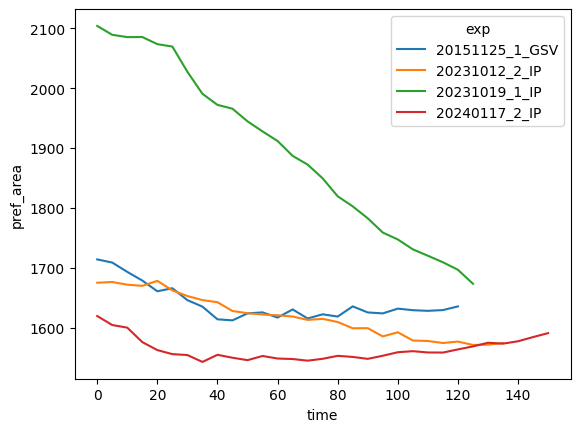

In [7]:
sns.lineplot(data=us_pref_areas, x='time', y='pref_area', hue='exp')
#plt.savefig(save_dir+'/unstretched_prefered_area.png', dpi=300, bbox_inches='tight')

In [8]:
pref_A_all=sorted(glob('C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Output\\*_data/*/*/*/Data/*pref_area.txt'))

In [9]:
dat=[]
for i in pref_A_all:
    frame=float(i.split('\\')[-4][-3:])
    exp=i.split('\\')[-4].split('_GFP')[0]
    pref_area=float(np.loadtxt(i))
    s_type=i.split('\\')[-4].split('_')[4]
    dat.append([exp, frame, pref_area, s_type])

In [10]:
all_pref_areas=pd.DataFrame(dat, columns=['exp', 'frame', 'pref_area', 'stretch_type'])
all_pref_areas['time']=(all_pref_areas.frame-1)
all_pref_areas.loc[all_pref_areas.exp=='20151125_1_GSV', 'time']=all_pref_areas.loc[all_pref_areas.exp=='20151125_1_GSV','time']/3
all_pref_areas=all_pref_areas[all_pref_areas.exp!='20151007_1_GSV']
all_pref_areas.loc[all_pref_areas.stretch_type=='uc', 'exp']='con_' +all_pref_areas.loc[all_pref_areas.stretch_type=='uc', 'exp'].astype(str)
all_pref_areas.loc[all_pref_areas.stretch_type=='us', 'exp']='inc_' +all_pref_areas.loc[all_pref_areas.stretch_type=='us', 'exp'].astype(str)
all_pref_areas.loc[all_pref_areas.stretch_type=='uf', 'exp']='ins_' +all_pref_areas.loc[all_pref_areas.stretch_type=='uf', 'exp'].astype(str)
all_pref_areas.loc[all_pref_areas.stretch_type=='uu', 'exp']='uns_' +all_pref_areas.loc[all_pref_areas.stretch_type=='uu', 'exp'].astype(str)
cell_density=(cell_data.groupby(["experiment", "time"]).cell_id_new.count()/cell_data.groupby(["experiment", "time"]).cell_area_microns.sum()).reset_index()
cell_density=cell_density.rename(columns={0:'cell_density'})    
all_pref_areas.time=all_pref_areas.time.astype(int)  
all_pref_areas=all_pref_areas.merge(cell_density, left_on=['exp', 'time'], right_on=['experiment', 'time'])
all_pref_areas['cd_norm']=all_pref_areas.cell_density/all_pref_areas.groupby(["exp"]).cell_density.transform("first")
all_pref_areas['cd_norm_recip']=1/all_pref_areas.cd_norm
all_pref_areas['pa_norm']=all_pref_areas.pref_area/all_pref_areas.groupby(["exp"]).pref_area.transform("first")
all_pref_areas=all_pref_areas.merge(exp_data[['experiment', 'time', 'total_area', 'cell_count', 'total_area_norm']], left_on=['exp', 'time'], right_on=['experiment', 'time'])
all_pref_areas['cell_count_norm']=all_pref_areas.cell_count/all_pref_areas.groupby(["exp"]).cell_count.transform("first")


In [11]:
all_pref_areas

,exp,frame,pref_area,stretch_type,time,experiment_x,cell_density,cd_norm,cd_norm_recip,pa_norm,experiment_y,total_area,cell_count,total_area_norm,cell_count_norm
0,con_20240412_2_IP,1.0,1583.387227,uc,0,con_20240412_2_IP,0.002809,1.000000,1.000000,1.000000,con_20240412_2_IP,162341.821624,456,1.000000,1.000000
1,con_20240503_2_IP,1.0,1649.200345,uc,0,con_20240503_2_IP,0.002740,1.000000,1.000000,1.000000,con_20240503_2_IP,150710.667920,413,1.000000,1.000000
2,inc_20231005_1_IP,1.0,1960.110504,us,0,inc_20231005_1_IP,0.002274,1.000000,1.000000,1.000000,inc_20231005_1_IP,93676.238527,213,1.000000,1.000000
3,inc_20240117_1_IP,1.0,2051.661126,us,0,inc_20240117_1_IP,0.002249,1.000000,1.000000,1.000000,inc_20240117_1_IP,123190.807959,277,1.000000,1.000000
4,inc_20240320_2_IN,1.0,1617.106065,us,0,inc_20240320_2_IN,0.002771,1.000000,1.000000,1.000000,inc_20240320_2_IN,43660.188054,121,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,uns_20240117_2_IP,131.0,1574.683425,uu,130,uns_20240117_2_IP,0.002731,0.994890,1.005137,0.972416,uns_20240117_2_IP,148309.593563,405,1.076932,1.071429
89,uns_20240117_2_IP,136.0,1573.185064,uu,135,uns_20240117_2_IP,0.002723,0.991989,1.008076,0.971491,uns_20240117_2_IP,149110.487462,406,1.082748,1.074074
90,uns_20240117_2_IP,141.0,1577.149463,uu,140,uns_20240117_2_IP,0.002709,0.987064,1.013106,0.973939,uns_20240117_2_IP,149854.539959,406,1.088151,1.074074
91,uns_20240117_2_IP,146.0,1584.163721,uu,145,uns_20240117_2_IP,0.002698,0.983109,1.017181,0.978270,uns_20240117_2_IP,150457.292619,406,1.092527,1.074074


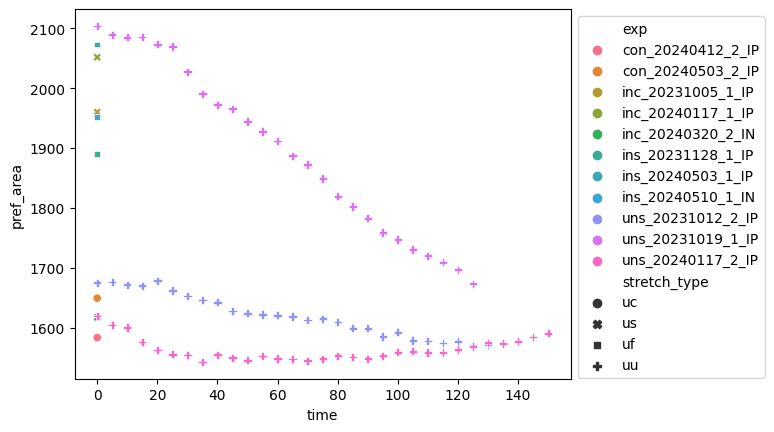

In [12]:
ax=sns.scatterplot(data=all_pref_areas, x='time', y='pref_area', hue='exp', style='stretch_type', )
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.savefig(save_dir+'/all_prefered_area.png', dpi=300, bbox_inches='tight')

In [13]:
us_data=cell_data[cell_data.stretch_type=='u']

In [14]:
us_PA_exp=np.unique(us_pref_areas.exp)[1:]

us_exp=np.unique(us_data.experiment)

In [15]:
us_exp

array(['uns_20231012_2_IP', 'uns_20231019_1_IP', 'uns_20240117_2_IP'],
      dtype=object)

<AxesSubplot: xlabel='time', ylabel='cell_area_microns'>

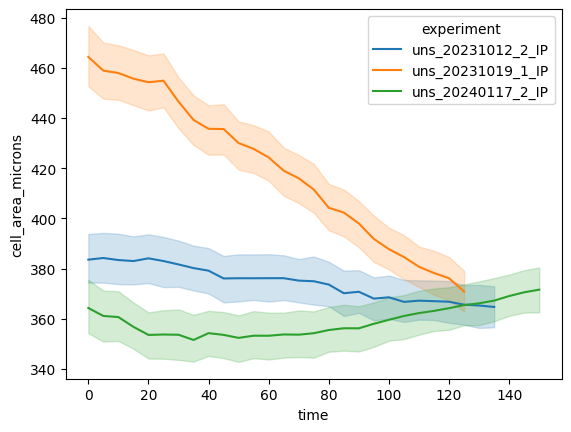

In [23]:
sns.lineplot(cell_data[cell_data.stretch_type=='u'], x='time', y='cell_area_microns', hue='experiment')

In [16]:


time=us_pref_areas[(us_pref_areas.exp==us_PA_exp[0])].time.values
GS0=[mechanics.GlobalStress(us_pref_areas[(us_pref_areas.exp==us_PA_exp[0])&(us_pref_areas.time==t)].pref_area.values, us_data[(us_data.experiment==us_exp[0])&(us_data.time==t)].cell_area_microns, Gamma, us_data[(us_data.experiment==us_exp[0])&(us_data.time==t)].cell_perimeter_microns, pref_perimeter) for t in time]



time=us_pref_areas[(us_pref_areas.exp==us_PA_exp[1])].time.values
GS1=[mechanics.GlobalStress(us_pref_areas[(us_pref_areas.exp==us_PA_exp[1])&(us_pref_areas.time==t)].pref_area.values, us_data[(us_data.experiment==us_exp[1])&(us_data.time==t)].cell_area_microns, Gamma, us_data[(us_data.experiment==us_exp[1])&(us_data.time==t)].cell_perimeter_microns, pref_perimeter) for t in time]



time=us_pref_areas[(us_pref_areas.exp==us_PA_exp[2])].time.values
GS2=[mechanics.GlobalStress(us_pref_areas[(us_pref_areas.exp==us_PA_exp[2])&(us_pref_areas.time==t)].pref_area.values, us_data[(us_data.experiment==us_exp[2])&(us_data.time==t)].cell_area_microns, Gamma, us_data[(us_data.experiment==us_exp[2])&(us_data.time==t)].cell_perimeter_microns, pref_perimeter) for t in time]

In [50]:
time0=us_pref_areas[(us_pref_areas.exp==us_PA_exp[0])].time.values
GS0_PA0=[mechanics.GlobalStress(us_pref_areas[(us_pref_areas.exp==us_PA_exp[0])&(us_pref_areas.time==0)].pref_area.values, us_data[(us_data.experiment==us_exp[0])&(us_data.time==t)].cell_area_microns, Gamma, us_data[(us_data.experiment==us_exp[0])&(us_data.time==t)].cell_perimeter_microns, pref_perimeter) for t in time0]



time1=us_pref_areas[(us_pref_areas.exp==us_PA_exp[1])].time.values
GS1_PA0=[mechanics.GlobalStress(us_pref_areas[(us_pref_areas.exp==us_PA_exp[1])&(us_pref_areas.time==0)].pref_area.values, us_data[(us_data.experiment==us_exp[1])&(us_data.time==t)].cell_area_microns, Gamma, us_data[(us_data.experiment==us_exp[1])&(us_data.time==t)].cell_perimeter_microns, pref_perimeter) for t in time1]



time2=us_pref_areas[(us_pref_areas.exp==us_PA_exp[2])].time.values
GS2_PA0=[mechanics.GlobalStress(us_pref_areas[(us_pref_areas.exp==us_PA_exp[2])&(us_pref_areas.time==0)].pref_area.values, us_data[(us_data.experiment==us_exp[2])&(us_data.time==t)].cell_area_microns, Gamma, us_data[(us_data.experiment==us_exp[2])&(us_data.time==t)].cell_perimeter_microns, pref_perimeter) for t in time2]

time0=us_pref_areas[(us_pref_areas.exp==us_PA_exp[0])].time.values
GS0_PAs=[mechanics.GlobalStress(us_pref_areas[(us_pref_areas.exp==us_PA_exp[0])&(us_pref_areas.time==0)].pref_area.values*(1-area_scaling*(t*60)), us_data[(us_data.experiment==us_exp[0])&(us_data.time==t)].cell_area_microns, Gamma, us_data[(us_data.experiment==us_exp[0])&(us_data.time==t)].cell_perimeter_microns, pref_perimeter) for t in time0]



time1=us_pref_areas[(us_pref_areas.exp==us_PA_exp[1])].time.values
GS1_PAs=[mechanics.GlobalStress(us_pref_areas[(us_pref_areas.exp==us_PA_exp[1])&(us_pref_areas.time==0)].pref_area.values*(1-area_scaling*(t*60)), us_data[(us_data.experiment==us_exp[1])&(us_data.time==t)].cell_area_microns, Gamma, us_data[(us_data.experiment==us_exp[1])&(us_data.time==t)].cell_perimeter_microns, pref_perimeter) for t in time1]



time2=us_pref_areas[(us_pref_areas.exp==us_PA_exp[2])].time.values
GS2_PAs=[mechanics.GlobalStress(us_pref_areas[(us_pref_areas.exp==us_PA_exp[2])&(us_pref_areas.time==0)].pref_area.values*(1-area_scaling*(t*60)), us_data[(us_data.experiment==us_exp[2])&(us_data.time==t)].cell_area_microns, Gamma, us_data[(us_data.experiment==us_exp[2])&(us_data.time==t)].cell_perimeter_microns, pref_perimeter) for t in time2]

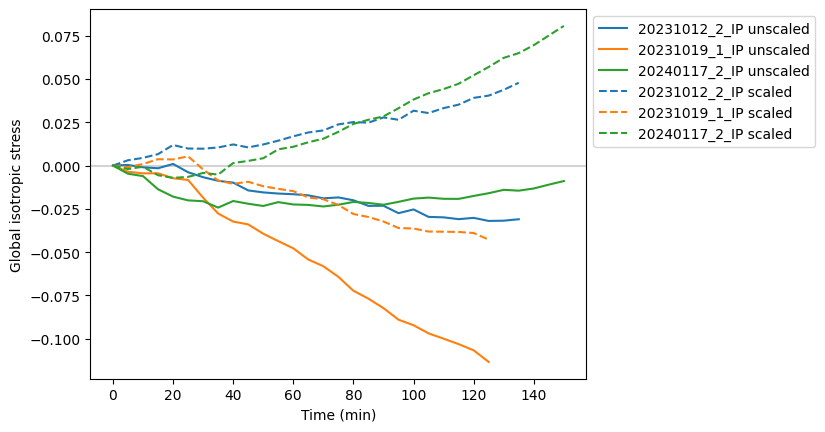

In [51]:
plt.plot(time0, GS0_PA0, label=us_PA_exp[0] + " unscaled", c='tab:blue')
plt.plot(time1, GS1_PA0, label=us_PA_exp[1] + " unscaled",c='tab:orange')
plt.plot(time2, GS2_PA0, label=us_PA_exp[2] + " unscaled",c='tab:green')

plt.plot(time0, GS0_PAs, label=us_PA_exp[0] + " scaled", c='tab:blue', linestyle='--')
plt.plot(time1, GS1_PAs, label=us_PA_exp[1] + " scaled", c='tab:orange', linestyle='--')
plt.plot(time2, GS2_PAs, label=us_PA_exp[2] + " scaled", c='tab:green', linestyle='--')
plt.legend(bbox_to_anchor=(1,1), frameon=True)
plt.axhline(0, c='lightgrey', zorder=0)

plt.ylabel("Global isotropic stress")
plt.xlabel("Time (min)")

plt.savefig(save_dir+'/GS_unstretched_scaling.png', dpi=300, bbox_inches='tight')

C:\Users\v35431nc\AppData\Local\Temp\ipykernel_14812\2527975756.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  plt.plot(time0, 4.45*us_data[(us_data.experiment==us_exp[0])].groupby('time').mean().cell_area_microns, label=us_PA_exp[0] + " 4.45 * mean area" , c='tab:blue', linestyle=':')
C:\Users\v35431nc\AppData\Local\Temp\ipykernel_14812\2527975756.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  plt.plot(time1, 4.45*us_data[(us_data.experiment==us_exp[1])].groupby('time').mean().cell_area_microns, label=us_PA_exp[1] + " 4.45 * mean area",c='tab:orange', linestyle=':')
C:\Users\v35431nc\AppData\Loc

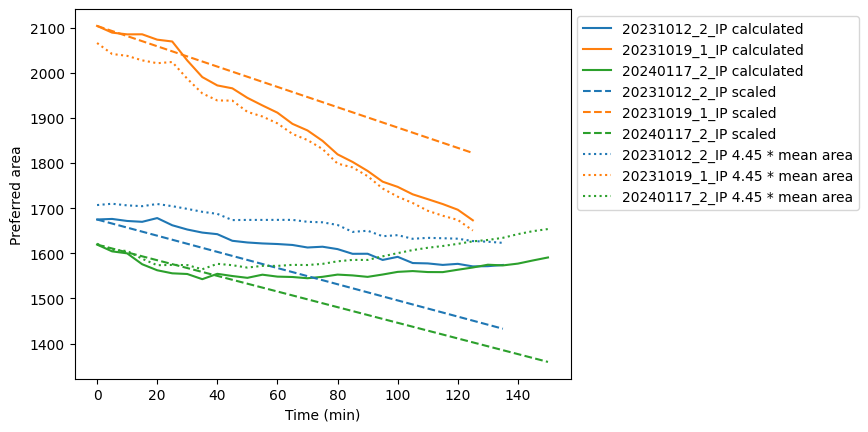

In [17]:
plt.plot(time0, us_pref_areas[(us_pref_areas.exp==us_PA_exp[0])].pref_area.values, label=us_PA_exp[0] + " calculated" , c='tab:blue')
plt.plot(time1, us_pref_areas[(us_pref_areas.exp==us_PA_exp[1])].pref_area.values, label=us_PA_exp[1] + " calculated",c='tab:orange')
plt.plot(time2, us_pref_areas[(us_pref_areas.exp==us_PA_exp[2])].pref_area.values, label=us_PA_exp[2] + " calculated",c='tab:green')

plt.plot(time0, us_pref_areas[(us_pref_areas.exp==us_PA_exp[0])&(us_pref_areas.time==0)].pref_area.values*(1-area_scaling*(time0*60)), label=us_PA_exp[0] + " scaled", c='tab:blue', linestyle='--')
plt.plot(time1, us_pref_areas[(us_pref_areas.exp==us_PA_exp[1])&(us_pref_areas.time==0)].pref_area.values*(1-area_scaling*(time1*60)), label=us_PA_exp[1] + " scaled", c='tab:orange', linestyle='--')
plt.plot(time2, us_pref_areas[(us_pref_areas.exp==us_PA_exp[2])&(us_pref_areas.time==0)].pref_area.values*(1-area_scaling*(time2*60)), label=us_PA_exp[2] + " scaled", c='tab:green', linestyle='--')

plt.plot(time0, 4.45*us_data[(us_data.experiment==us_exp[0])].groupby('time').mean().cell_area_microns, label=us_PA_exp[0] + " 4.45 * mean area" , c='tab:blue', linestyle=':')
plt.plot(time1, 4.45*us_data[(us_data.experiment==us_exp[1])].groupby('time').mean().cell_area_microns, label=us_PA_exp[1] + " 4.45 * mean area",c='tab:orange', linestyle=':')
plt.plot(time2, 4.45*us_data[(us_data.experiment==us_exp[2])].groupby('time').mean().cell_area_microns, label=us_PA_exp[2] + " 4.45 * mean area",c='tab:green', linestyle=':')


plt.legend(bbox_to_anchor=(1,1), frameon=True)



#plt.axhline(0, c='lightgrey', zorder=0)

plt.ylabel("Preferred area")
plt.xlabel("Time (min)")

plt.savefig(save_dir+'/pref_area_scaling.png', dpi=300, bbox_inches='tight')

In [56]:
us_pref_areas['exp'] = 'uns_' + us_pref_areas['exp'].astype(str)

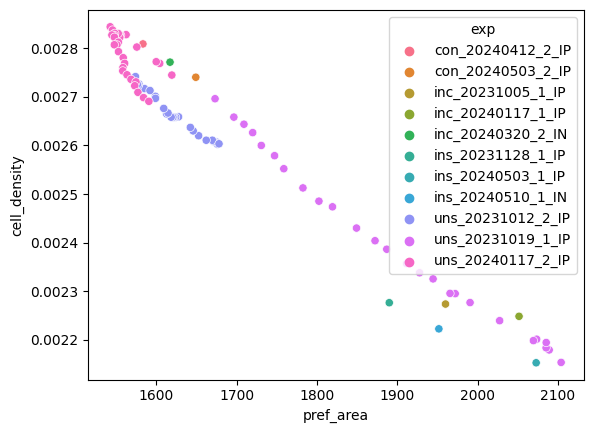

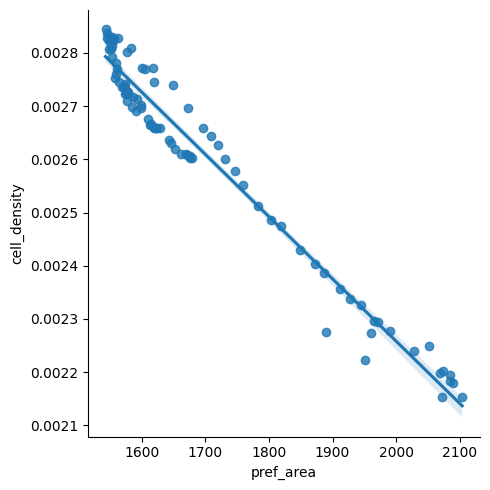

In [25]:
sns.scatterplot(all_pref_areas, x="pref_area", y="cell_density", hue='exp')
plt.show()
sns.lmplot(all_pref_areas, x="pref_area", y="cell_density")

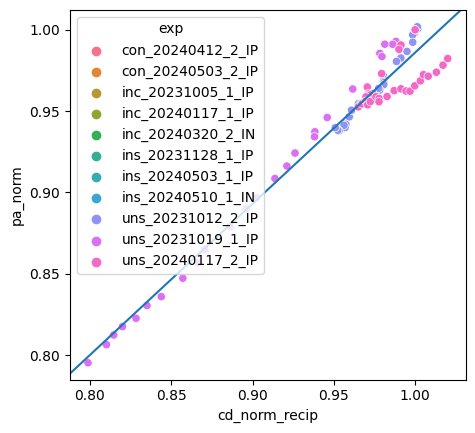

In [28]:
sns.scatterplot(all_pref_areas,y='pa_norm',x='cd_norm_recip', hue='exp')
plt.axline(xy1=(0.8, 0.8), slope=0.93)
plt.gca().set_aspect('equal')

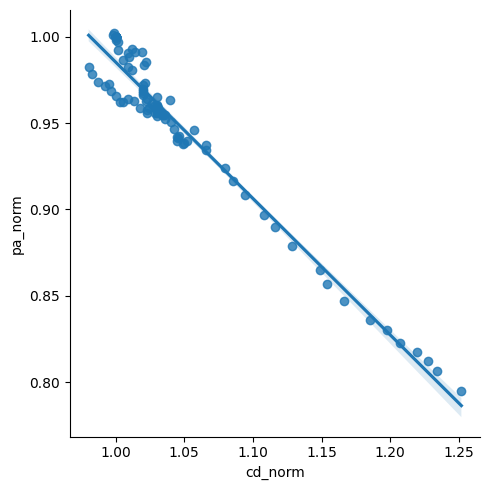

In [65]:
g=sns.lmplot(all_pref_areas,y='pa_norm',x='cd_norm')


In [20]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(all_pref_areas.cd_norm_recip,all_pref_areas.pa_norm)
intercept

0.03879089205989217

In [21]:
stats.linregress(all_pref_areas.mean_area_norm,all_pref_areas.pa_norm)

LinregressResult(slope=0.9488873188310769, intercept=0.03879089205989117, rvalue=0.9768059357639476, pvalue=1.0524572201186115e-62, stderr=0.021805000576841885, intercept_stderr=0.020987149094755107)

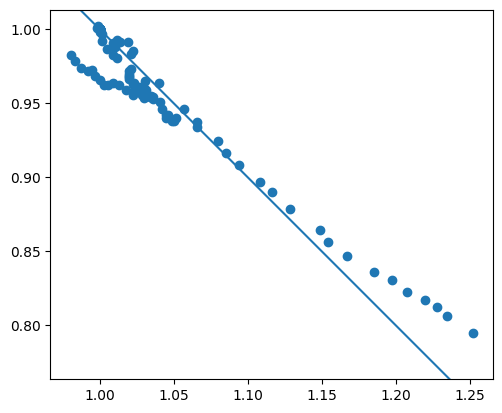

In [138]:
plt.scatter(all_pref_areas.cd_norm, all_pref_areas.pa_norm)
plt.axline(xy1=(1.225, 0.775), slope=-1)

plt.gca().set_aspect('equal')

In [60]:
slope, intercept, r_value, p_value, std_err =stats.linregress(all_pref_areas[all_pref_areas.stretch_type=='uu'].cd_norm,all_pref_areas[all_pref_areas.stretch_type=='uu'].pa_norm)

<AxesSubplot: xlabel='time', ylabel='cd_norm'>

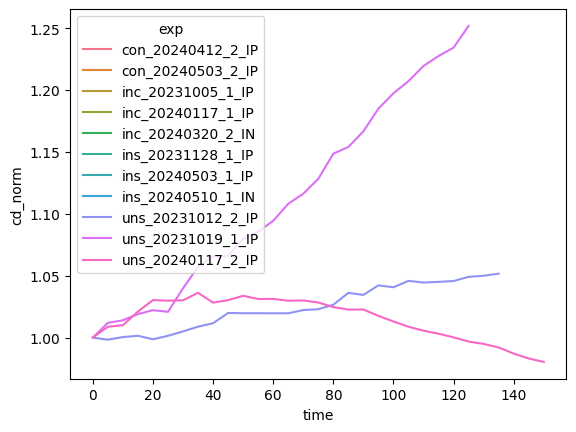

In [63]:
sns.lineplot(all_pref_areas, x='time', y='cd_norm', hue='exp')

In [55]:
us_pref_areas

,exp,frame,pref_area,time
0,20151125_1_GSV,1.0,1713.942637,0.0
1,20151125_1_GSV,16.0,1708.649528,5.0
2,20151125_1_GSV,31.0,1693.085318,10.0
3,20151125_1_GSV,46.0,1678.619598,15.0
4,20151125_1_GSV,61.0,1660.683019,20.0
...,...,...,...,...
105,20240117_2_IP,131.0,1574.683425,130.0
106,20240117_2_IP,136.0,1573.185064,135.0
107,20240117_2_IP,141.0,1577.149463,140.0
108,20240117_2_IP,146.0,1584.163721,145.0


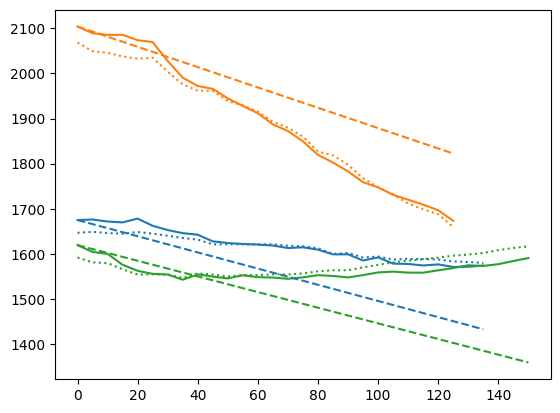

In [61]:
plt.plot(time0, us_pref_areas[(us_pref_areas.exp==us_exp[0])].pref_area.values, label=us_exp[0] + " calculated" , c='tab:blue')
plt.plot(time1, us_pref_areas[(us_pref_areas.exp==us_exp[1])].pref_area.values, label=us_exp[1] + " calculated",c='tab:orange')
plt.plot(time2, us_pref_areas[(us_pref_areas.exp==us_exp[2])].pref_area.values, label=us_exp[2] + " calculated",c='tab:green')

plt.plot(time0, us_pref_areas[(us_pref_areas.exp==us_exp[0])&(us_pref_areas.time==0)].pref_area.values*(1-area_scaling*(time0*60)), label=us_exp[0] + " scaled", c='tab:blue', linestyle='--')
plt.plot(time1, us_pref_areas[(us_pref_areas.exp==us_exp[1])&(us_pref_areas.time==0)].pref_area.values*(1-area_scaling*(time1*60)), label=us_exp[1] + " scaled", c='tab:orange', linestyle='--')
plt.plot(time2, us_pref_areas[(us_pref_areas.exp==us_exp[2])&(us_pref_areas.time==0)].pref_area.values*(1-area_scaling*(time2*60)), label=us_exp[2] + " scaled", c='tab:green', linestyle='--')

plt.plot(time0, all_pref_areas[(all_pref_areas.exp==us_exp[0])&(all_pref_areas.time==0)].pref_area.values*(slope*all_pref_areas[(all_pref_areas.exp==us_exp[0])].cd_norm+intercept), label=us_exp[0] + " 1/cd_norm" , c='tab:blue', linestyle=':')
plt.plot(time1, all_pref_areas[(all_pref_areas.exp==us_exp[1])&(all_pref_areas.time==0)].pref_area.values*(slope*all_pref_areas[(all_pref_areas.exp==us_exp[1])].cd_norm+intercept), label=us_exp[1] + " 1/cd_norm",c='tab:orange', linestyle=':')
plt.plot(time2, all_pref_areas[(all_pref_areas.exp==us_exp[2])&(all_pref_areas.time==0)].pref_area.values*(slope*all_pref_areas[(all_pref_areas.exp==us_exp[2])].cd_norm+intercept), label=us_exp[2] + " 1/cd_norm",c='tab:green', linestyle=':')


In [17]:
all_pref_areas['mean_area']=1/(all_pref_areas.cell_density)

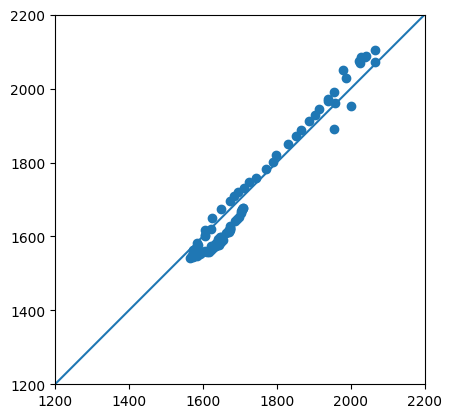

In [157]:
plt.scatter(4.45*all_pref_areas.mean_area, all_pref_areas.pref_area)
plt.gca().set_aspect('equal')
plt.xlim(1200, 2200)
plt.ylim(1200, 2200)
plt.gca().set_aspect('equal')
plt.axline(xy1=(0, 0), slope=1)

plt.show()

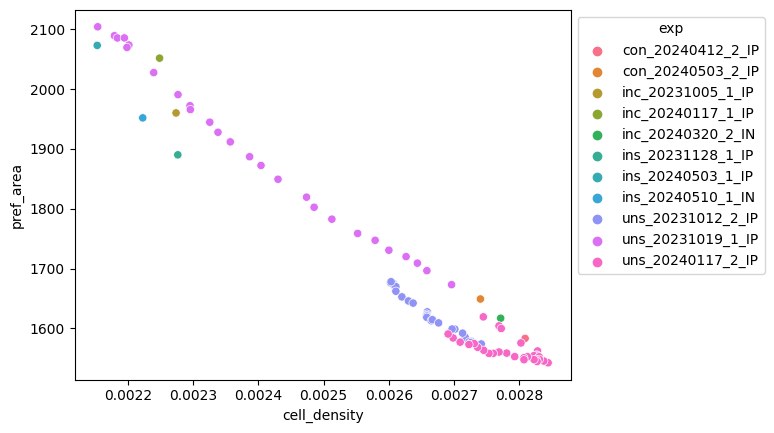

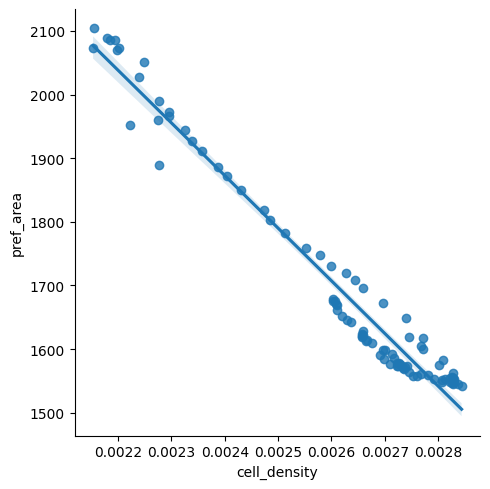

In [220]:
g=sns.scatterplot(all_pref_areas, x='cell_density', y='pref_area', hue='exp')
sns.move_legend(g, "upper left", bbox_to_anchor=(1,1), frameon=True)

plt.show()


sns.lmplot(all_pref_areas, x='cell_density', y='pref_area')


In [144]:
stats.linregress(all_pref_areas.mean_area,all_pref_areas.pref_area)

LinregressResult(slope=5.164106486709225, intercept=-292.9066683389008, rvalue=0.9866608968714908, pvalue=1.5304647809484908e-73, stderr=0.08931651376860593, intercept_stderr=34.55188523096225)

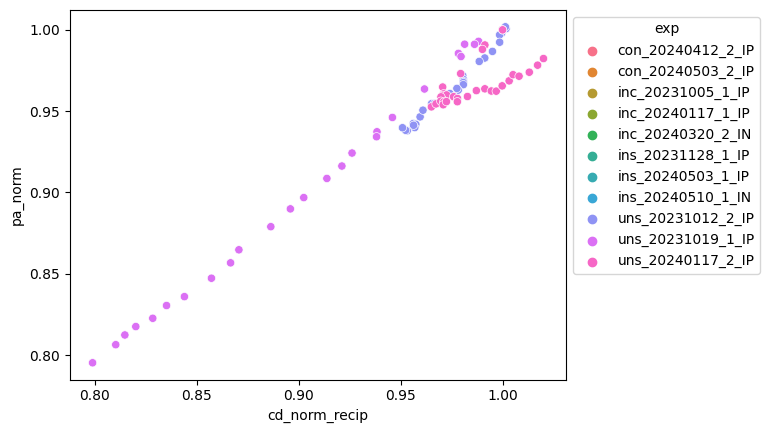

In [43]:
g=sns.scatterplot(all_pref_areas, x='cd_norm_recip', y='pa_norm', hue='exp')
sns.move_legend(g, "upper left", bbox_to_anchor=(1,1), frameon=True)


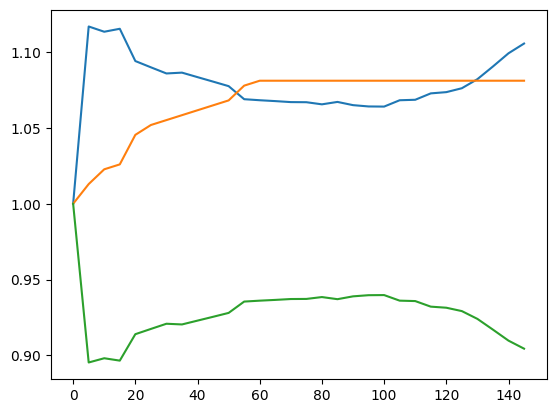

In [45]:
t1=np.linspace(0, 145, 30)
plt.plot(t1,exp_data[exp_data.experiment=="ins_20231128_1_IP"].mean_area_per_cell/(exp_data[(exp_data.experiment=="ins_20231128_1_IP")&(exp_data.time==0)].mean_area_per_cell.values))
plt.plot(t1, exp_data[exp_data.experiment=="ins_20231128_1_IP"].cell_count/(exp_data[(exp_data.experiment=="ins_20231128_1_IP")&(exp_data.time==0)].cell_count.values))
plt.plot(t1,1/(exp_data[exp_data.experiment=="ins_20231128_1_IP"].mean_area_per_cell/(exp_data[(exp_data.experiment=="ins_20231128_1_IP")&(exp_data.time==0)].mean_area_per_cell.values)))


In [46]:
all_pref_areas['cc_norm_recip']=1/all_pref_areas.cell_count_norm

In [110]:
all_pref_areas[all_pref_areas.stretch_type=='uu']

,exp,frame,pref_area,stretch_type,time,experiment_x,cell_density,cd_norm,cd_norm_recip,pa_norm,experiment_y,total_area,cell_count,total_area_norm,cell_count_norm,cc_norm_recip
8,uns_20231012_2_IP,1.0,1674.938735,uu,0,uns_20231012_2_IP,0.002607,1.000000,1.000000,1.000000,uns_20231012_2_IP,167242.894834,436,1.000000,1.000000,1.000000
9,uns_20231012_2_IP,6.0,1676.182440,uu,5,uns_20231012_2_IP,0.002603,0.998305,1.001698,1.000743,uns_20231012_2_IP,167911.110087,437,1.003995,1.002294,0.997712
10,uns_20231012_2_IP,11.0,1671.692420,uu,10,uns_20231012_2_IP,0.002608,1.000416,0.999584,0.998062,uns_20231012_2_IP,167940.188336,438,1.004169,1.004587,0.995434
11,uns_20231012_2_IP,16.0,1669.787687,uu,15,uns_20231012_2_IP,0.002611,1.001454,0.998548,0.996925,uns_20231012_2_IP,168149.142592,439,1.005419,1.006881,0.993166
12,uns_20231012_2_IP,21.0,1678.096001,uu,20,uns_20231012_2_IP,0.002603,0.998633,1.001369,1.001885,uns_20231012_2_IP,168624.184749,439,1.008259,1.006881,0.993166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,uns_20240117_2_IP,131.0,1574.683425,uu,130,uns_20240117_2_IP,0.002731,0.994890,1.005137,0.972416,uns_20240117_2_IP,148309.593563,405,1.076932,1.071429,0.933333
89,uns_20240117_2_IP,136.0,1573.185064,uu,135,uns_20240117_2_IP,0.002723,0.991989,1.008076,0.971491,uns_20240117_2_IP,149110.487462,406,1.082748,1.074074,0.931034
90,uns_20240117_2_IP,141.0,1577.149463,uu,140,uns_20240117_2_IP,0.002709,0.987064,1.013106,0.973939,uns_20240117_2_IP,149854.539959,406,1.088151,1.074074,0.931034
91,uns_20240117_2_IP,146.0,1584.163721,uu,145,uns_20240117_2_IP,0.002698,0.983109,1.017181,0.978270,uns_20240117_2_IP,150457.292619,406,1.092527,1.074074,0.931034


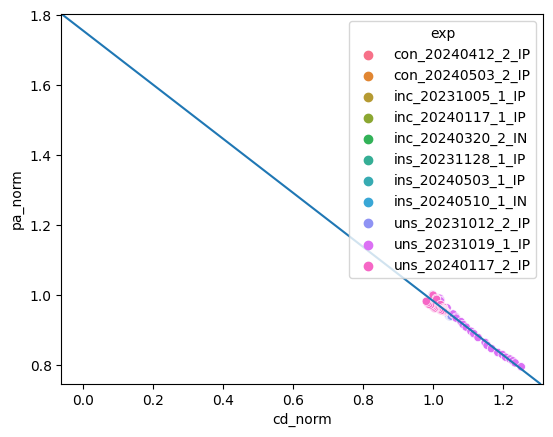

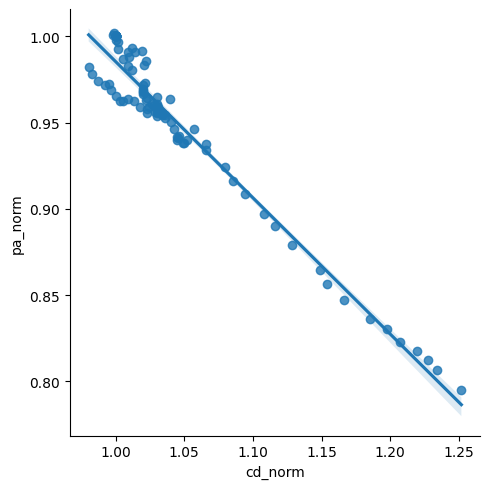

In [219]:
sns.scatterplot(all_pref_areas, y='pa_norm', x='cd_norm', hue='exp')
plt.axline(xy1=(0, intercept), slope=slope)
plt.gca().set_aspect('equal')
plt.show()
sns.lmplot(all_pref_areas, y='pa_norm', x='cd_norm')


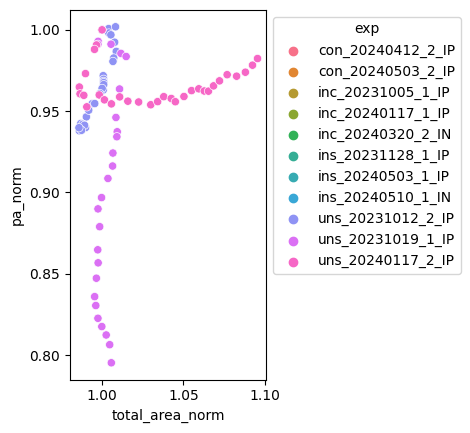

In [104]:
g=sns.scatterplot(all_pref_areas, y='pa_norm', x='total_area_norm', hue='exp')
#plt.axline(xy1=(1, 1), slope=-0.8)
sns.move_legend(g, "upper left", bbox_to_anchor=(1,1), frameon=True)
plt.gca().set_aspect('equal')
plt.show()


In [112]:
stats.linregress(all_pref_areas[all_pref_areas.stretch_type=='uu'].cd_norm,all_pref_areas[all_pref_areas.stretch_type=='uu'].pa_norm)

LinregressResult(slope=-0.7724972131757853, intercept=1.7555975602284346, rvalue=-0.9789510829002719, pvalue=4.636604299636606e-59, stderr=0.01767784381043713, intercept_stderr=0.01855608855225462)

C:\Users\v35431nc\AppData\Local\Temp\ipykernel_14812\4041320882.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.plot(time0[1:], all_pref_areas[(all_pref_areas.exp==us_exp[0])&(all_pref_areas.time==0)].pref_area.values*(slope*all_pref_areas[(all_pref_areas.exp==us_exp[0])].cd_norm+intercept)[1:], label=us_exp[0] + " 4.45 * mean area" , c='tab:blue', linestyle=':')
C:\Users\v35431nc\AppData\Local\Temp\ipykernel_14812\4041320882.py:10: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:

Text(0.5, 0, 'time')

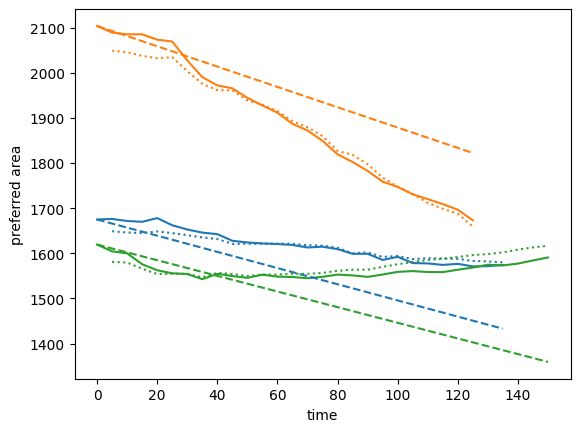

In [249]:
plt.plot(time0, us_pref_areas[(us_pref_areas.exp==us_exp[0])].pref_area.values, label=us_exp[0] + " calculated" , c='tab:blue')
plt.plot(time1, us_pref_areas[(us_pref_areas.exp==us_exp[1])].pref_area.values, label=us_exp[1] + " calculated",c='tab:orange')
plt.plot(time2, us_pref_areas[(us_pref_areas.exp==us_exp[2])].pref_area.values, label=us_exp[2] + " calculated",c='tab:green')

plt.plot(time0, us_pref_areas[(us_pref_areas.exp==us_exp[0])&(us_pref_areas.time==0)].pref_area.values*(1-area_scaling*(time0*60)), label=us_exp[0] + " scaled", c='tab:blue', linestyle='--')
plt.plot(time1, us_pref_areas[(us_pref_areas.exp==us_exp[1])&(us_pref_areas.time==0)].pref_area.values*(1-area_scaling*(time1*60)), label=us_exp[1] + " scaled", c='tab:orange', linestyle='--')
plt.plot(time2, us_pref_areas[(us_pref_areas.exp==us_exp[2])&(us_pref_areas.time==0)].pref_area.values*(1-area_scaling*(time2*60)), label=us_exp[2] + " scaled", c='tab:green', linestyle='--')

plt.plot(time0[1:], all_pref_areas[(all_pref_areas.exp==us_exp[0])&(all_pref_areas.time==0)].pref_area.values*(slope*all_pref_areas[(all_pref_areas.exp==us_exp[0])].cd_norm+intercept)[1:], label=us_exp[0] + " 4.45 * mean area" , c='tab:blue', linestyle=':')
plt.plot(time1[1:], all_pref_areas[(all_pref_areas.exp==us_exp[1])&(all_pref_areas.time==0)].pref_area.values*(slope*all_pref_areas[(all_pref_areas.exp==us_exp[1])].cd_norm+intercept)[1:], label=us_exp[1] + " 4.45 * mean area",c='tab:orange', linestyle=':')
plt.plot(time2[1:], all_pref_areas[(all_pref_areas.exp==us_exp[2])&(all_pref_areas.time==0)].pref_area.values*(slope*all_pref_areas[(all_pref_areas.exp==us_exp[2])].cd_norm+intercept)[1:], label=us_exp[2] + " 4.45 * mean area",c='tab:green', linestyle=':')

plt.ylabel("preferred area")
plt.xlabel("time")


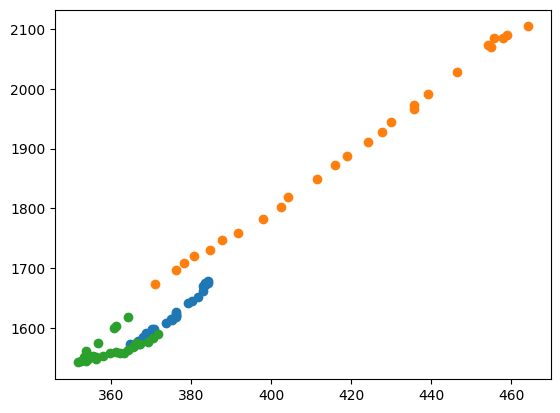

In [222]:
plt.scatter(all_pref_areas[(all_pref_areas.exp==us_exp[0])].mean_area, all_pref_areas[(all_pref_areas.exp==us_exp[0])].pref_area.values, label=us_exp[0] + " calculated" , c='tab:blue')
plt.scatter(all_pref_areas[(all_pref_areas.exp==us_exp[1])].mean_area, all_pref_areas[(all_pref_areas.exp==us_exp[1])].pref_area.values, label=us_exp[1] + " calculated",c='tab:orange')
plt.scatter(all_pref_areas[(all_pref_areas.exp==us_exp[2])].mean_area, all_pref_areas[(all_pref_areas.exp==us_exp[2])].pref_area.values, label=us_exp[2] + " calculated",c='tab:green')
#plt.axline(xy1=(1600, 1600), slope=1)
#plt.gca().set_aspect('equal')
plt.xlabel("mean cell area")
plt.ylabel()

In [131]:
all_pref_areas

,exp,frame,pref_area,stretch_type,time,experiment_x,cell_density,cd_norm,cd_norm_recip,pa_norm,experiment_y,total_area,cell_count,total_area_norm,cell_count_norm,mean_area
0,con_20240412_2_IP,1.0,1583.387227,uc,0,con_20240412_2_IP,0.002809,1.000000,1.000000,1.000000,con_20240412_2_IP,162341.821624,456,1.000000,1.000000,356.012767
1,con_20240503_2_IP,1.0,1649.200345,uc,0,con_20240503_2_IP,0.002740,1.000000,1.000000,1.000000,con_20240503_2_IP,150710.667920,413,1.000000,1.000000,364.916871
2,inc_20231005_1_IP,1.0,1960.110504,us,0,inc_20231005_1_IP,0.002274,1.000000,1.000000,1.000000,inc_20231005_1_IP,93676.238527,213,1.000000,1.000000,439.794547
3,inc_20240117_1_IP,1.0,2051.661126,us,0,inc_20240117_1_IP,0.002249,1.000000,1.000000,1.000000,inc_20240117_1_IP,123190.807959,277,1.000000,1.000000,444.732159
4,inc_20240320_2_IN,1.0,1617.106065,us,0,inc_20240320_2_IN,0.002771,1.000000,1.000000,1.000000,inc_20240320_2_IN,43660.188054,121,1.000000,1.000000,360.828000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,uns_20240117_2_IP,131.0,1574.683425,uu,130,uns_20240117_2_IP,0.002731,0.994890,1.005137,0.972416,uns_20240117_2_IP,148309.593563,405,1.076932,1.071429,366.196527
89,uns_20240117_2_IP,136.0,1573.185064,uu,135,uns_20240117_2_IP,0.002723,0.991989,1.008076,0.971491,uns_20240117_2_IP,149110.487462,406,1.082748,1.074074,367.267210
90,uns_20240117_2_IP,141.0,1577.149463,uu,140,uns_20240117_2_IP,0.002709,0.987064,1.013106,0.973939,uns_20240117_2_IP,149854.539959,406,1.088151,1.074074,369.099852
91,uns_20240117_2_IP,146.0,1584.163721,uu,145,uns_20240117_2_IP,0.002698,0.983109,1.017181,0.978270,uns_20240117_2_IP,150457.292619,406,1.092527,1.074074,370.584465


In [117]:
intercept=0

In [62]:

time0=us_pref_areas[(us_pref_areas.exp==us_exp[0])].time.values
GS0_PA_cc=[mechanics.GlobalStress(np.array(all_pref_areas[(all_pref_areas.exp==us_exp[0])&(all_pref_areas.time==0)].pref_area.values*(slope*all_pref_areas[(all_pref_areas.exp==us_exp[0])].cd_norm.values+intercept))[n], us_data[(us_data.experiment==us_exp[0])&(us_data.time==time0[n])].cell_area_microns, Gamma, us_data[(us_data.experiment==us_exp[0])&(us_data.time==time0[n])].cell_perimeter_microns, pref_perimeter) for n in range(len(time0))]



time1=us_pref_areas[(us_pref_areas.exp==us_exp[1])].time.values
GS1_PA_cc=[mechanics.GlobalStress(np.array(all_pref_areas[(all_pref_areas.exp==us_exp[1])&(all_pref_areas.time==0)].pref_area.values*(slope*all_pref_areas[(all_pref_areas.exp==us_exp[1])].cd_norm+intercept))[n], us_data[(us_data.experiment==us_exp[1])&(us_data.time==time1[n])].cell_area_microns, Gamma, us_data[(us_data.experiment==us_exp[1])&(us_data.time==time1[n])].cell_perimeter_microns, pref_perimeter) for n in range(len(time1))]



time2=us_pref_areas[(us_pref_areas.exp==us_exp[2])].time.values
GS2_PA_cc=[mechanics.GlobalStress(np.array(all_pref_areas[(all_pref_areas.exp==us_exp[2])&(all_pref_areas.time==0)].pref_area.values*(slope*all_pref_areas[(all_pref_areas.exp==us_exp[2])].cd_norm+intercept))[n], us_data[(us_data.experiment==us_exp[2])&(us_data.time==time2[n])].cell_area_microns, Gamma, us_data[(us_data.experiment==us_exp[2])&(us_data.time==time2[n])].cell_perimeter_microns, pref_perimeter) for n in range(len(time2))]

In [63]:
GS0_PA_cc[0]=GS0_PA0[0]
GS1_PA_cc[0]=GS1_PA0[0]
GS2_PA_cc[0]=GS2_PA0[0]


Text(0.5, 0, 'Time (min)')

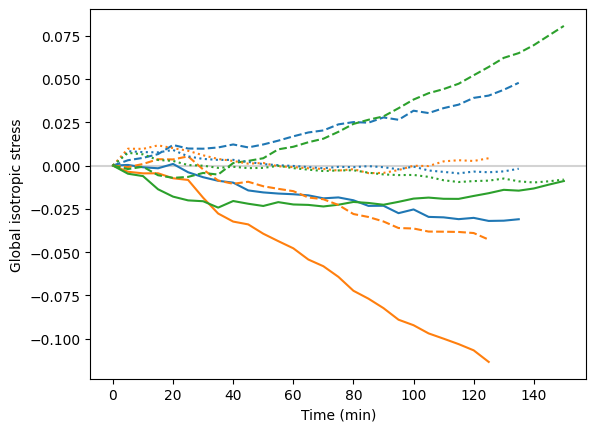

In [250]:
plt.plot(time0, GS0_PA0, label=us_PA_exp[0] + " unscaled", c='tab:blue')
plt.plot(time1, GS1_PA0, label=us_PA_exp[1] + " unscaled",c='tab:orange')
plt.plot(time2, GS2_PA0, label=us_PA_exp[2] + " unscaled",c='tab:green')

plt.plot(time0, GS0_PAs, label=us_PA_exp[0] + " scaled", c='tab:blue', linestyle='--')
plt.plot(time1, GS1_PAs, label=us_PA_exp[1] + " scaled", c='tab:orange', linestyle='--')
plt.plot(time2, GS2_PAs, label=us_PA_exp[2] + " scaled", c='tab:green', linestyle='--')


plt.plot(time0, GS0_PA_cc, label=us_PA_exp[0] + " scaled", c='tab:blue', linestyle=':')
plt.plot(time1, GS1_PA_cc, label=us_PA_exp[1] + " scaled", c='tab:orange', linestyle=':')
plt.plot(time2, GS2_PA_cc, label=us_PA_exp[2] + " scaled", c='tab:green', linestyle=':')

#plt.legend(bbox_to_anchor=(1,1), frameon=True)
plt.axhline(0, c='lightgrey', zorder=0)

plt.ylabel("Global isotropic stress")
plt.xlabel("Time (min)")

#plt.savefig(save_dir+'/GS_unstretched_scaling.png', dpi=300, bbox_inches='tight')

In [164]:
time=np.unique(cell_data[cell_data.experiment=='ins_20231128_1_IP'].time)
time

array([  0,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,
        65,  70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125,
       130, 135, 140, 145], dtype=int64)

In [28]:
exp_data['cd_norm']=exp_data.cell_density/exp_data.groupby('experiment').cell_density.transform("first")

In [261]:
exp_data

,index,experiment,time,total_area,cell_count,cell_density,mean_area_per_cell,div_rate,x_scale,y_scale,stretch_type,total_area_norm,cd_norm,tot_area_recip,tot_area_norm_recip
0,0,con_20240412_2_IP,0,162341.821624,456,0.002809,356.012767,NaN,1.000000,1.000000,c,1.000000,1.000000,0.000006,1.000000
1,1,con_20240412_2_IP,5,162360.525222,459,0.002827,353.726634,3.0,1.023521,0.979161,c,1.000115,1.006463,0.000006,0.999885
2,2,con_20240412_2_IP,10,163430.283338,459,0.002809,356.057262,0.0,1.043675,0.966127,c,1.006705,0.999875,0.000006,0.993340
3,3,con_20240412_2_IP,15,163003.023028,460,0.002822,354.354398,1.0,1.056766,0.951195,c,1.004073,1.004680,0.000006,0.995944
4,4,con_20240412_2_IP,20,163119.189904,463,0.002838,352.309265,3.0,1.071842,0.937979,c,1.004788,1.010512,0.000006,0.995234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,346,uns_20240117_2_IP,130,148309.593563,405,0.002731,366.196527,1.0,1.038606,1.025614,u,1.076932,0.994890,0.000007,0.928564
347,347,uns_20240117_2_IP,135,149110.487462,406,0.002723,367.267210,1.0,1.040383,1.026606,u,1.082748,0.991989,0.000007,0.923576
348,348,uns_20240117_2_IP,140,149854.539959,406,0.002709,369.099852,0.0,1.041300,1.030141,u,1.088151,0.987064,0.000007,0.918990
349,349,uns_20240117_2_IP,145,150457.292619,406,0.002698,370.584465,0.0,1.042626,1.032506,u,1.092527,0.983109,0.000007,0.915309


In [179]:
np.unique(exp_data.experiment)

array(['con_20240412_2_IP', 'con_20240503_2_IP', 'inc_20231005_1_IP',
       'inc_20240117_1_IP', 'inc_20240320_2_IN', 'ins_20231121_1_IN',
       'ins_20231128_1_IP', 'ins_20240503_1_IP', 'ins_20240510_1_IN',
       'uns_20231012_2_IP', 'uns_20231019_1_IP', 'uns_20240117_2_IP'],
      dtype=object)

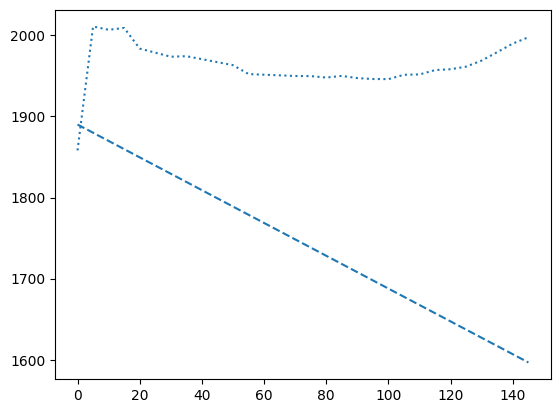

In [177]:
plt.plot(time, all_pref_areas[(all_pref_areas.exp=='ins_20231128_1_IP')&(all_pref_areas.time==0)].pref_area.values*(1-area_scaling*(time*60)), label='ins_20231128_1_IP' + " scaled", c='tab:blue', linestyle='--')
plt.plot(time, all_pref_areas[(all_pref_areas.exp=='ins_20231128_1_IP')&(all_pref_areas.time==0)].pref_area.values*(1-area_scaling*(time*60)), label='ins_20231128_1_IP' + " scaled", c='tab:blue', linestyle='--')
plt.plot(time, all_pref_areas[(all_pref_areas.exp=='ins_20231128_1_IP')&(all_pref_areas.time==0)].pref_area.values*(1-area_scaling*(time*60)), label='ins_20231128_1_IP' + " scaled", c='tab:blue', linestyle='--')

plt.plot(time, all_pref_areas[(all_pref_areas.exp=='ins_20231128_1_IP')&(all_pref_areas.time==0)].pref_area.values*(slope*exp_data[(exp_data.experiment=='ins_20231128_1_IP')].cd_norm+intercept).values, label='ins_20231128_1_IP'  , c='tab:blue', linestyle=':')
# plt.plot(time1, all_pref_areas[(all_pref_areas.exp==us_exp[1])&(all_pref_areas.time==0)].pref_area.values*(0.95*all_pref_areas[(all_pref_areas.exp==us_exp[1])].cc_norm_recip+0.047), label=us_exp[1] + " 4.45 * mean area",c='tab:orange', linestyle=':')
# plt.plot(time2, all_pref_areas[(all_pref_areas.exp==us_exp[2])&(all_pref_areas.time==0)].pref_area.values*(0.95*all_pref_areas[(all_pref_areas.exp==us_exp[2])].cc_norm_recip+0.047), label=us_exp[2] + " 4.45 * mean area",c='tab:green', linestyle=':')


In [29]:
def GlobalStresstest(pref_area, A, Gamma, L, L_0, Pext):
    """GlobalsStress of the cells as a function of cell area"""
    globalStress = np.sum(((A/pref_area) - 1 + 0.5*Gamma*(L/A)*(L - L_0*(pref_area**(1/2))))*A)/np.sum(A) -Pext;
    return globalStress;

def derivative_GlobalStresstest(pref_area, A, Gamma, L, L_0, Pext):
    """first derivative of global stress of the cells as a function of cell area"""
    d_globalStress = np.sum((-(A/(pref_area**2))- 0.25*Gamma*(L/A)*(L_0*(pref_area**(-1/2))))*A)/np.sum(A);
    return d_globalStress;

In [30]:
def get_pref_areatest(cell_areas, gamma, L, L_0, mean_cell_area, Pext):
    """
    Uses Newtons method to find the value of the dimensional area when the global stress is zero.
    """
    sol = optimize.root_scalar(GlobalStresstest,args=(cell_areas, gamma, L, L_0, Pext),  x0=mean_cell_area, fprime=derivative_GlobalStresstest, method='newton')
    pref_area=sol.root
    return pref_area

In [31]:
exp_test=us_exp[1]

In [32]:
pa_01=get_pref_areatest(cell_data[(cell_data.experiment=='uns_20231012_2_IP')&(cell_data.time==0)].cell_area_microns.values, Gamma,cell_data[(cell_data.experiment=='uns_20231012_2_IP')&(cell_data.time==0)].cell_perimeter_microns.values, pref_perimeter, np.mean(cell_data[(cell_data.experiment=='uns_20231012_2_IP')&(cell_data.time==0)].cell_area_microns.values), -0.1 )

In [244]:
mechanics.GlobalStress

<function utils.mechanics.GlobalStress(pref_area, A, Gamma, L, L_0)>

In [33]:
mechanics.GlobalStress(pa_01,cell_data[(cell_data.experiment=='uns_20231012_2_IP')&(cell_data.time==0)].cell_area_microns.values, Gamma,cell_data[(cell_data.experiment=='uns_20231012_2_IP')&(cell_data.time==0)].cell_perimeter_microns.values, pref_perimeter)

-0.1

In [34]:
pa=get_pref_areatest(cell_data[(cell_data.experiment=='uns_20231012_2_IP')&(cell_data.time==0)].cell_area_microns.values, Gamma,cell_data[(cell_data.experiment=='uns_20231012_2_IP')&(cell_data.time==0)].cell_perimeter_microns.values, pref_perimeter, np.mean(cell_data[(cell_data.experiment=='uns_20231012_2_IP')&(cell_data.time==0)].cell_area_microns.values), 0 )

In [35]:
pa_005=get_pref_areatest(cell_data[(cell_data.experiment=='uns_20231012_2_IP')&(cell_data.time==0)].cell_area_microns.values, Gamma,cell_data[(cell_data.experiment=='uns_20231012_2_IP')&(cell_data.time==0)].cell_perimeter_microns.values, pref_perimeter, np.mean(cell_data[(cell_data.experiment=='uns_20231012_2_IP')&(cell_data.time==0)].cell_area_microns.values), -0.05 )

In [36]:
pa_001=get_pref_areatest(cell_data[(cell_data.experiment=='uns_20231012_2_IP')&(cell_data.time==0)].cell_area_microns.values, Gamma,cell_data[(cell_data.experiment=='uns_20231012_2_IP')&(cell_data.time==0)].cell_perimeter_microns.values, pref_perimeter, np.mean(cell_data[(cell_data.experiment=='uns_20231012_2_IP')&(cell_data.time==0)].cell_area_microns.values), 0.01 )

(array([  1.,   0.,   0.,   0.,   3.,  54., 207., 134.,  36.,   1.]),
 array([-1.06603438, -0.92877299, -0.7915116 , -0.65425021, -0.51698882,
        -0.37972743, -0.24246604, -0.10520465,  0.03205674,  0.16931813,
         0.30657952]),
 <BarContainer object of 10 artists>)

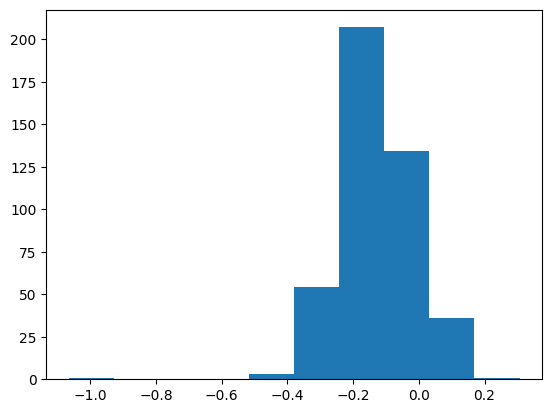

In [37]:
area_01=cell_data[(cell_data.experiment=='uns_20231012_2_IP')&(cell_data.time==0)].cell_area_microns.values/pa_01
perimeter_01=cell_data[(cell_data.experiment=='uns_20231012_2_IP')&(cell_data.time==0)].cell_perimeter_microns.values/np.sqrt(pa_01)
pressure_01=area_01-1
tension_01=Gamma*(perimeter_01-pref_perimeter)
Peff_01=pressure_01+(tension_01*perimeter_01)/(2*area_01)
plt.hist(Peff_01)

(array([  1.,   0.,   0.,   0.,   7.,  87., 201., 113.,  26.,   1.]),
 array([-0.96658625, -0.83329897, -0.70001169, -0.56672441, -0.43343713,
        -0.30014985, -0.16686257, -0.03357529,  0.09971199,  0.23299927,
         0.36628655]),
 <BarContainer object of 10 artists>)

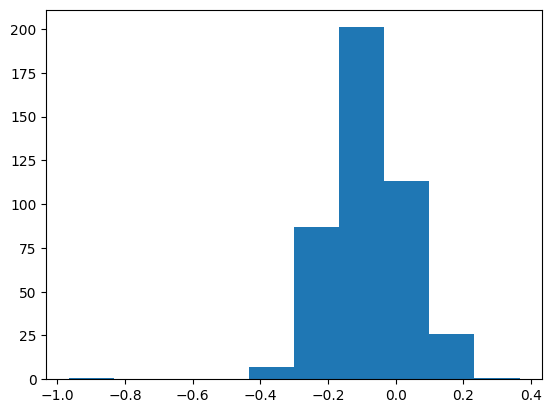

In [38]:
area_005=cell_data[(cell_data.experiment=='uns_20231012_2_IP')&(cell_data.time==0)].cell_area_microns.values/pa_005
perimeter_005=cell_data[(cell_data.experiment=='uns_20231012_2_IP')&(cell_data.time==0)].cell_perimeter_microns.values/np.sqrt(pa_005)
pressure_005=area_005-1
tension_005=Gamma*(perimeter_005-pref_perimeter)
Peff_005=pressure_005+(tension_005*perimeter_005)/(2*area_005)
plt.hist(Peff_005)

(array([  1.,   0.,   0.,   0.,   9., 118., 185., 101.,  21.,   1.]),
 array([-0.85877734, -0.73384213, -0.60890693, -0.48397173, -0.35903653,
        -0.23410132, -0.10916612,  0.01576908,  0.14070429,  0.26563949,
         0.39057469]),
 <BarContainer object of 10 artists>)

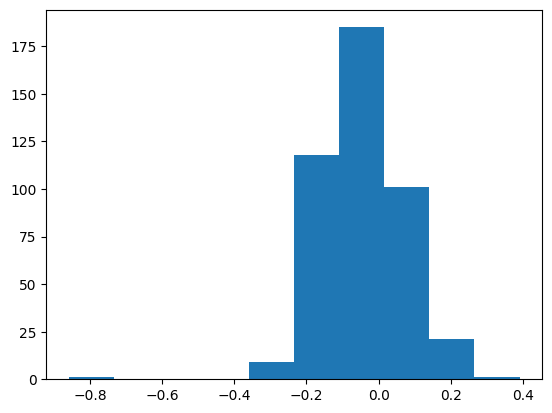

In [39]:
area_001=cell_data[(cell_data.experiment=='uns_20231012_2_IP')&(cell_data.time==0)].cell_area_microns.values/pa_001
perimeter_001=cell_data[(cell_data.experiment=='uns_20231012_2_IP')&(cell_data.time==0)].cell_perimeter_microns.values/np.sqrt(pa_001)
pressure_001=area_005-1
tension_001=Gamma*(perimeter_001-pref_perimeter)
Peff_001=pressure_001+(tension_001*perimeter_001)/(2*area_001)
plt.hist(Peff_001)

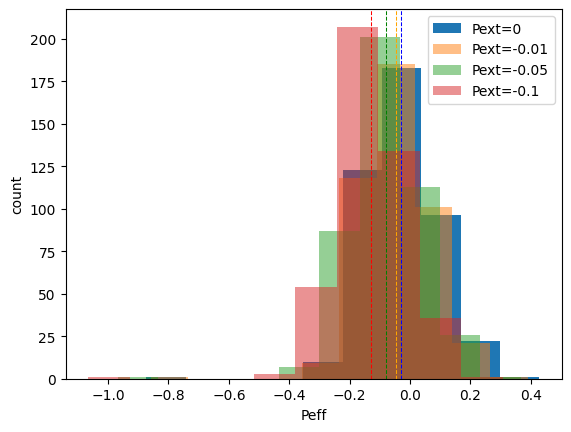

In [215]:
plt.hist(cell_data[(cell_data.experiment=='uns_20231012_2_IP')&(cell_data.time==0)].cell_P_eff_nd, label='Pext=0')
plt.hist(Peff_001, alpha=0.5, label='Pext=-0.01')
plt.hist(Peff_005, alpha=0.5,label='Pext=-0.05')
plt.hist(Peff_01, alpha=0.5,label= 'Pext=-0.1')

#plt.axvline(0, c='red', linestyle='--', linewidth=0.75)

plt.axvline(np.mean(cell_data[(cell_data.experiment=='uns_20231012_2_IP')&(cell_data.time==0)].cell_P_eff_nd), c='blue', linestyle='--', linewidth=0.75)
plt.axvline(np.mean(Peff_001), c='orange', linestyle='--', linewidth=0.75)
plt.axvline(np.mean(Peff_005), c='green', linestyle='--', linewidth=0.75)
plt.axvline(np.mean(Peff_01), c='red', linestyle='--', linewidth=0.75)
plt.xlabel("Peff")
plt.ylabel("count")
plt.legend()

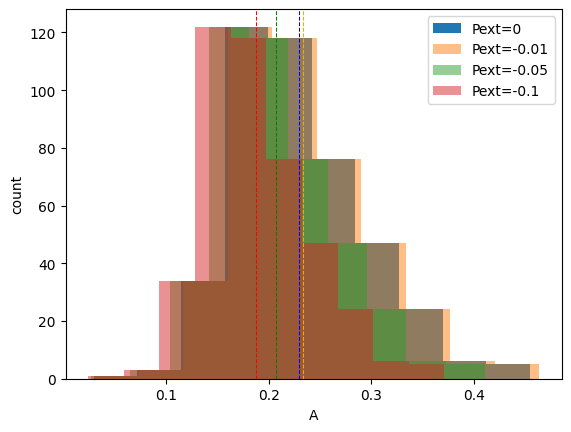

In [216]:
plt.hist(cell_data[(cell_data.experiment=='uns_20231012_2_IP')&(cell_data.time==0)].cell_area_nd, label='Pext=0')
plt.hist(area_001, alpha=0.5, label='Pext=-0.01')
plt.hist(area_005, alpha=0.5, label='Pext=-0.05')
plt.hist(area_01, alpha=0.5, label='Pext=-0.1')


plt.axvline(np.mean(cell_data[(cell_data.experiment=='uns_20231012_2_IP')&(cell_data.time==0)].cell_area_nd), c='blue', linestyle='--', linewidth=0.75)
plt.axvline(np.mean(area_001), c='orange', linestyle='--', linewidth=0.75)
plt.axvline(np.mean(area_005), c='green', linestyle='--', linewidth=0.75)
plt.axvline(np.mean(area_01), c='red', linestyle='--', linewidth=0.75)

plt.xlabel("A")
plt.ylabel("count")
plt.legend()

In [42]:
np.unique(all_pref_areas.exp)

array(['con_20240412_2_IP', 'con_20240503_2_IP', 'inc_20231005_1_IP',
       'inc_20240117_1_IP', 'inc_20240320_2_IN', 'ins_20231128_1_IP',
       'ins_20240503_1_IP', 'ins_20240510_1_IN', 'uns_20231012_2_IP',
       'uns_20231019_1_IP', 'uns_20240117_2_IP'], dtype=object)

In [43]:
np.unique(cell_data[(cell_data.experiment=='ins_20240510_1_IN')].time)

array([  0,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,
        65,  70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125,
       130], dtype=int64)

In [211]:
mu6=2*np.sqrt(6*np.tan(np.pi/6))
mu6

3.7224194364083982

In [212]:
def Peff_6(A0, A, L, Gamma, L0):
    mu6=2*np.sqrt(6*np.tan(np.pi/6))
    return (A/A0 -1 +0.5*Gamma(mu6**2 - L0*mu6/(np.sqrt(A/A0)) ))

In [ ]:
optimize.root_scalar(Peff, args=())

In [ ]:
all_pref_areas[(all_pref_areas.exp=='ins_20231128_1_IP')&(all_pref_areas.time==0)].pref_area.values*(slope*exp_data[(exp_data.experiment=='ins_20231128_1_IP')].cd_norm+intercept).values

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, 'Time (min)')

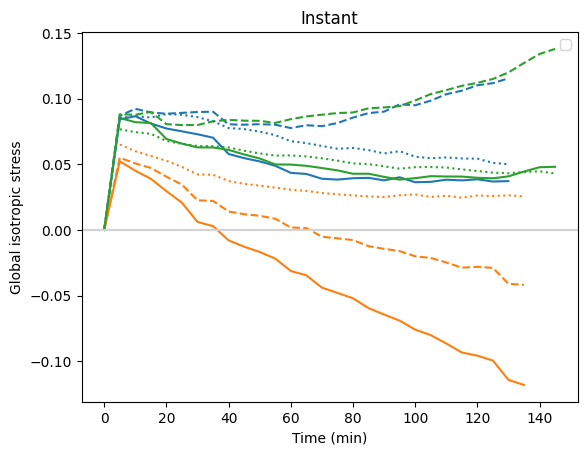

In [265]:
plt.plot(np.unique(cell_data[(cell_data.experiment=='ins_20240510_1_IN')].time),[mechanics.GlobalStress(all_pref_areas[all_pref_areas.exp=='ins_20240510_1_IN'].pref_area.values, cell_data[(cell_data.experiment=='ins_20240510_1_IN')&(cell_data.time==t)].cell_area_microns.values, Gamma,cell_data[(cell_data.experiment=='ins_20240510_1_IN')&(cell_data.time==t)].cell_perimeter_microns.values, pref_perimeter) for t in np.unique(cell_data[(cell_data.experiment=='ins_20240510_1_IN')].time)])
plt.plot(np.unique(cell_data[(cell_data.experiment=='ins_20240503_1_IP')].time),[mechanics.GlobalStress(all_pref_areas[all_pref_areas.exp=='ins_20240503_1_IP'].pref_area.values, cell_data[(cell_data.experiment=='ins_20240503_1_IP')&(cell_data.time==t)].cell_area_microns.values, Gamma,cell_data[(cell_data.experiment=='ins_20240503_1_IP')&(cell_data.time==t)].cell_perimeter_microns.values, pref_perimeter) for t in np.unique(cell_data[(cell_data.experiment=='ins_20240503_1_IP')].time)])
plt.plot(np.unique(cell_data[(cell_data.experiment=='ins_20231128_1_IP')].time),[mechanics.GlobalStress(all_pref_areas[all_pref_areas.exp=='ins_20231128_1_IP'].pref_area.values, cell_data[(cell_data.experiment=='ins_20231128_1_IP')&(cell_data.time==t)].cell_area_microns.values, Gamma,cell_data[(cell_data.experiment=='ins_20231128_1_IP')&(cell_data.time==t)].cell_perimeter_microns.values, pref_perimeter) for t in np.unique(cell_data[(cell_data.experiment=='ins_20231128_1_IP')].time)])


plt.plot(np.unique(cell_data[(cell_data.experiment=='ins_20240510_1_IN')].time),[mechanics.GlobalStress(all_pref_areas[all_pref_areas.exp=='ins_20240510_1_IN'].pref_area.values*(1-area_scaling*(t*60)), cell_data[(cell_data.experiment=='ins_20240510_1_IN')&(cell_data.time==t)].cell_area_microns.values, Gamma,cell_data[(cell_data.experiment=='ins_20240510_1_IN')&(cell_data.time==t)].cell_perimeter_microns.values, pref_perimeter) for t in np.unique(cell_data[(cell_data.experiment=='ins_20240510_1_IN')].time)], linestyle='--', c='tab:blue')
plt.plot(np.unique(cell_data[(cell_data.experiment=='ins_20240503_1_IP')].time),[mechanics.GlobalStress(all_pref_areas[all_pref_areas.exp=='ins_20240503_1_IP'].pref_area.values*(1-area_scaling*(t*60)), cell_data[(cell_data.experiment=='ins_20240503_1_IP')&(cell_data.time==t)].cell_area_microns.values, Gamma,cell_data[(cell_data.experiment=='ins_20240503_1_IP')&(cell_data.time==t)].cell_perimeter_microns.values, pref_perimeter) for t in np.unique(cell_data[(cell_data.experiment=='ins_20240503_1_IP')].time)], linestyle='--', c='tab:orange')
plt.plot(np.unique(cell_data[(cell_data.experiment=='ins_20231128_1_IP')].time),[mechanics.GlobalStress(all_pref_areas[all_pref_areas.exp=='ins_20231128_1_IP'].pref_area.values*(1-area_scaling*(t*60)), cell_data[(cell_data.experiment=='ins_20231128_1_IP')&(cell_data.time==t)].cell_area_microns.values, Gamma,cell_data[(cell_data.experiment=='ins_20231128_1_IP')&(cell_data.time==t)].cell_perimeter_microns.values, pref_perimeter) for t in np.unique(cell_data[(cell_data.experiment=='ins_20231128_1_IP')].time)], linestyle='--', c='tab:green')

# plt.plot(np.unique(cell_data[(cell_data.experiment=='ins_20240510_1_IN')].time)[1:],[mechanics.GlobalStress(all_pref_areas[(all_pref_areas.exp=='ins_20240510_1_IN')&(all_pref_areas.time==0)].pref_area.values*(slope*exp_data[(exp_data.experiment=='ins_20240510_1_IN')].cd_norm+intercept).values[n], cell_data[(cell_data.experiment=='ins_20240510_1_IN')&(cell_data.time==np.unique(cell_data[(cell_data.experiment=='ins_20240510_1_IN')].time)[n])].cell_area_microns.values, Gamma,cell_data[(cell_data.experiment=='ins_20240510_1_IN')&(cell_data.time==np.unique(cell_data[(cell_data.experiment=='ins_20240510_1_IN')].time)[n])].cell_perimeter_microns.values, pref_perimeter) for n in range(len(np.unique(cell_data[(cell_data.experiment=='ins_20240510_1_IN')].time)))][1:], linestyle=':', color='tab:blue')
# plt.plot(np.unique(cell_data[(cell_data.experiment=='ins_20240503_1_IP')].time)[1:],[mechanics.GlobalStress(all_pref_areas[(all_pref_areas.exp=='ins_20240503_1_IP')&(all_pref_areas.time==0)].pref_area.values*(slope*exp_data[(exp_data.experiment=='ins_20240503_1_IP')].cd_norm+intercept).values[n], cell_data[(cell_data.experiment=='ins_20240503_1_IP')&(cell_data.time==np.unique(cell_data[(cell_data.experiment=='ins_20240503_1_IP')].time)[n])].cell_area_microns.values, Gamma,cell_data[(cell_data.experiment=='ins_20240503_1_IP')&(cell_data.time==np.unique(cell_data[(cell_data.experiment=='ins_20240503_1_IP')].time)[n])].cell_perimeter_microns.values, pref_perimeter) for n in range(len(np.unique(cell_data[(cell_data.experiment=='ins_20240503_1_IP')].time)))][1:], linestyle=':', color='tab:orange')
# plt.plot(np.unique(cell_data[(cell_data.experiment=='ins_20231128_1_IP')].time)[1:],[mechanics.GlobalStress(all_pref_areas[(all_pref_areas.exp=='ins_20231128_1_IP')&(all_pref_areas.time==0)].pref_area.values*(slope*exp_data[(exp_data.experiment=='ins_20231128_1_IP')].cd_norm+intercept).values[n], cell_data[(cell_data.experiment=='ins_20231128_1_IP')&(cell_data.time==np.unique(cell_data[(cell_data.experiment=='ins_20231128_1_IP')].time)[n])].cell_area_microns.values, Gamma,cell_data[(cell_data.experiment=='ins_20231128_1_IP')&(cell_data.time==np.unique(cell_data[(cell_data.experiment=='ins_20231128_1_IP')].time)[n])].cell_perimeter_microns.values, pref_perimeter) for n in range(len(np.unique(cell_data[(cell_data.experiment=='ins_20231128_1_IP')].time)))][1:], linestyle=':', color='tab:green')

plt.plot(np.unique(cell_data[(cell_data.experiment=='ins_20240510_1_IN')].time)[1:],[mechanics.GlobalStress(all_pref_areas[(all_pref_areas.exp=='ins_20240510_1_IN')&(all_pref_areas.time==0)].pref_area.values*(0.5*((1/1.25) +(1/0.9)))*(slope*exp_data[(exp_data.experiment=='ins_20240510_1_IN')].cd_norm+intercept).values[n], cell_data[(cell_data.experiment=='ins_20240510_1_IN')&(cell_data.time==np.unique(cell_data[(cell_data.experiment=='ins_20240510_1_IN')].time)[n])].cell_area_microns.values, Gamma,cell_data[(cell_data.experiment=='ins_20240510_1_IN')&(cell_data.time==np.unique(cell_data[(cell_data.experiment=='ins_20240510_1_IN')].time)[n])].cell_perimeter_microns.values, pref_perimeter) for n in range(len(np.unique(cell_data[(cell_data.experiment=='ins_20240510_1_IN')].time)))][1:], linestyle=':', color='tab:blue')
plt.plot(np.unique(cell_data[(cell_data.experiment=='ins_20240503_1_IP')].time)[1:],[mechanics.GlobalStress(all_pref_areas[(all_pref_areas.exp=='ins_20240503_1_IP')&(all_pref_areas.time==0)].pref_area.values*(0.5*((1/1.25) +(1/0.9)))*(slope*exp_data[(exp_data.experiment=='ins_20240503_1_IP')].cd_norm+intercept).values[n], cell_data[(cell_data.experiment=='ins_20240503_1_IP')&(cell_data.time==np.unique(cell_data[(cell_data.experiment=='ins_20240503_1_IP')].time)[n])].cell_area_microns.values, Gamma,cell_data[(cell_data.experiment=='ins_20240503_1_IP')&(cell_data.time==np.unique(cell_data[(cell_data.experiment=='ins_20240503_1_IP')].time)[n])].cell_perimeter_microns.values, pref_perimeter) for n in range(len(np.unique(cell_data[(cell_data.experiment=='ins_20240503_1_IP')].time)))][1:], linestyle=':', color='tab:orange')
plt.plot(np.unique(cell_data[(cell_data.experiment=='ins_20231128_1_IP')].time)[1:],[mechanics.GlobalStress(all_pref_areas[(all_pref_areas.exp=='ins_20231128_1_IP')&(all_pref_areas.time==0)].pref_area.values*(0.5*((1/1.25) +(1/0.9)))*(slope*exp_data[(exp_data.experiment=='ins_20231128_1_IP')].cd_norm+intercept).values[n], cell_data[(cell_data.experiment=='ins_20231128_1_IP')&(cell_data.time==np.unique(cell_data[(cell_data.experiment=='ins_20231128_1_IP')].time)[n])].cell_area_microns.values, Gamma,cell_data[(cell_data.experiment=='ins_20231128_1_IP')&(cell_data.time==np.unique(cell_data[(cell_data.experiment=='ins_20231128_1_IP')].time)[n])].cell_perimeter_microns.values, pref_perimeter) for n in range(len(np.unique(cell_data[(cell_data.experiment=='ins_20231128_1_IP')].time)))][1:], linestyle=':', color='tab:green')


plt.axhline(0, c='lightgrey')


plt.legend(bbox_to_anchor=(1,1), frameon=True)
plt.axhline(0, c='lightgrey', zorder=0)
plt.title("Instant")

plt.ylabel("Global isotropic stress")
plt.xlabel("Time (min)")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, 'Time (min)')

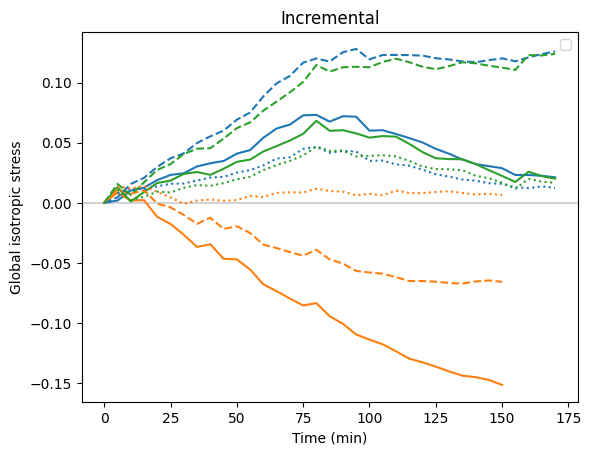

In [252]:
plt.plot(np.unique(cell_data[(cell_data.experiment=='inc_20231005_1_IP')].time),[mechanics.GlobalStress(all_pref_areas[all_pref_areas.exp=='inc_20231005_1_IP'].pref_area.values, cell_data[(cell_data.experiment=='inc_20231005_1_IP')&(cell_data.time==t)].cell_area_microns.values, Gamma,cell_data[(cell_data.experiment=='inc_20231005_1_IP')&(cell_data.time==t)].cell_perimeter_microns.values, pref_perimeter) for t in np.unique(cell_data[(cell_data.experiment=='inc_20231005_1_IP')].time)])
plt.plot(np.unique(cell_data[(cell_data.experiment=='inc_20240117_1_IP')].time),[mechanics.GlobalStress(all_pref_areas[all_pref_areas.exp=='inc_20240117_1_IP'].pref_area.values, cell_data[(cell_data.experiment=='inc_20240117_1_IP')&(cell_data.time==t)].cell_area_microns.values, Gamma,cell_data[(cell_data.experiment=='inc_20240117_1_IP')&(cell_data.time==t)].cell_perimeter_microns.values, pref_perimeter) for t in np.unique(cell_data[(cell_data.experiment=='inc_20240117_1_IP')].time)])
plt.plot(np.unique(cell_data[(cell_data.experiment=='inc_20240320_2_IN')].time),[mechanics.GlobalStress(all_pref_areas[all_pref_areas.exp=='inc_20240320_2_IN'].pref_area.values, cell_data[(cell_data.experiment=='inc_20240320_2_IN')&(cell_data.time==t)].cell_area_microns.values, Gamma,cell_data[(cell_data.experiment=='inc_20240320_2_IN')&(cell_data.time==t)].cell_perimeter_microns.values, pref_perimeter) for t in np.unique(cell_data[(cell_data.experiment=='inc_20240320_2_IN')].time)])

plt.plot(np.unique(cell_data[(cell_data.experiment=='inc_20231005_1_IP')].time),[mechanics.GlobalStress(all_pref_areas[all_pref_areas.exp=='inc_20231005_1_IP'].pref_area.values*(1-area_scaling*(t*60)), cell_data[(cell_data.experiment=='inc_20231005_1_IP')&(cell_data.time==t)].cell_area_microns.values, Gamma,cell_data[(cell_data.experiment=='inc_20231005_1_IP')&(cell_data.time==t)].cell_perimeter_microns.values, pref_perimeter) for t in np.unique(cell_data[(cell_data.experiment=='inc_20231005_1_IP')].time)], linestyle='--', c='tab:blue')
plt.plot(np.unique(cell_data[(cell_data.experiment=='inc_20240117_1_IP')].time),[mechanics.GlobalStress(all_pref_areas[all_pref_areas.exp=='inc_20240117_1_IP'].pref_area.values*(1-area_scaling*(t*60)), cell_data[(cell_data.experiment=='inc_20240117_1_IP')&(cell_data.time==t)].cell_area_microns.values, Gamma,cell_data[(cell_data.experiment=='inc_20240117_1_IP')&(cell_data.time==t)].cell_perimeter_microns.values, pref_perimeter) for t in np.unique(cell_data[(cell_data.experiment=='inc_20240117_1_IP')].time)], linestyle='--', c='tab:orange')
plt.plot(np.unique(cell_data[(cell_data.experiment=='inc_20240320_2_IN')].time),[mechanics.GlobalStress(all_pref_areas[all_pref_areas.exp=='inc_20240320_2_IN'].pref_area.values*(1-area_scaling*(t*60)), cell_data[(cell_data.experiment=='inc_20240320_2_IN')&(cell_data.time==t)].cell_area_microns.values, Gamma,cell_data[(cell_data.experiment=='inc_20240320_2_IN')&(cell_data.time==t)].cell_perimeter_microns.values, pref_perimeter) for t in np.unique(cell_data[(cell_data.experiment=='inc_20240320_2_IN')].time)], linestyle='--', c='tab:green')

plt.plot(np.unique(cell_data[(cell_data.experiment=='inc_20231005_1_IP')].time)[1:],[mechanics.GlobalStress(all_pref_areas[(all_pref_areas.exp=='inc_20231005_1_IP')&(all_pref_areas.time==0)].pref_area.values*(slope*exp_data[(exp_data.experiment=='inc_20231005_1_IP')].cd_norm+intercept).values[n], cell_data[(cell_data.experiment=='inc_20231005_1_IP')&(cell_data.time==np.unique(cell_data[(cell_data.experiment=='inc_20231005_1_IP')].time)[n])].cell_area_microns.values, Gamma,cell_data[(cell_data.experiment=='inc_20231005_1_IP')&(cell_data.time==np.unique(cell_data[(cell_data.experiment=='inc_20231005_1_IP')].time)[n])].cell_perimeter_microns.values, pref_perimeter) for n in range(len(np.unique(cell_data[(cell_data.experiment=='inc_20231005_1_IP')].time)))][1:], linestyle=':', color='tab:blue')
plt.plot(np.unique(cell_data[(cell_data.experiment=='inc_20240117_1_IP')].time)[1:],[mechanics.GlobalStress(all_pref_areas[(all_pref_areas.exp=='inc_20240117_1_IP')&(all_pref_areas.time==0)].pref_area.values*(slope*exp_data[(exp_data.experiment=='inc_20240117_1_IP')].cd_norm+intercept).values[n], cell_data[(cell_data.experiment=='inc_20240117_1_IP')&(cell_data.time==np.unique(cell_data[(cell_data.experiment=='inc_20240117_1_IP')].time)[n])].cell_area_microns.values, Gamma,cell_data[(cell_data.experiment=='inc_20240117_1_IP')&(cell_data.time==np.unique(cell_data[(cell_data.experiment=='inc_20240117_1_IP')].time)[n])].cell_perimeter_microns.values, pref_perimeter) for n in range(len(np.unique(cell_data[(cell_data.experiment=='inc_20240117_1_IP')].time)))][1:], linestyle=':', color='tab:orange')
plt.plot(np.unique(cell_data[(cell_data.experiment=='inc_20240320_2_IN')].time)[1:],[mechanics.GlobalStress(all_pref_areas[(all_pref_areas.exp=='inc_20240320_2_IN')&(all_pref_areas.time==0)].pref_area.values*(slope*exp_data[(exp_data.experiment=='inc_20240320_2_IN')].cd_norm+intercept).values[n], cell_data[(cell_data.experiment=='inc_20240320_2_IN')&(cell_data.time==np.unique(cell_data[(cell_data.experiment=='inc_20240320_2_IN')].time)[n])].cell_area_microns.values, Gamma,cell_data[(cell_data.experiment=='inc_20240320_2_IN')&(cell_data.time==np.unique(cell_data[(cell_data.experiment=='inc_20240320_2_IN')].time)[n])].cell_perimeter_microns.values, pref_perimeter) for n in range(len(np.unique(cell_data[(cell_data.experiment=='inc_20240320_2_IN')].time)))][1:], linestyle=':', color='tab:green')

# plt.plot(np.unique(cell_data[(cell_data.experiment=='inc_20231005_1_IP')].time),[mechanics.GlobalStress(all_pref_areas[(all_pref_areas.exp=='inc_20231005_1_IP')&(all_pref_areas.time==0)].pref_area.values*(0.5*((1/1.25) +(1/0.9)))*(slope*exp_data[(exp_data.experiment=='inc_20231005_1_IP')].cd_norm+intercept).values[n], cell_data[(cell_data.experiment=='inc_20231005_1_IP')&(cell_data.time==np.unique(cell_data[(cell_data.experiment=='inc_20231005_1_IP')].time)[n])].cell_area_microns.values, Gamma,cell_data[(cell_data.experiment=='inc_20231005_1_IP')&(cell_data.time==np.unique(cell_data[(cell_data.experiment=='inc_20231005_1_IP')].time)[n])].cell_perimeter_microns.values, pref_perimeter) for n in range(len(np.unique(cell_data[(cell_data.experiment=='inc_20231005_1_IP')].time)))], linestyle=':', color='tab:blue')
# plt.plot(np.unique(cell_data[(cell_data.experiment=='inc_20240117_1_IP')].time),[mechanics.GlobalStress(all_pref_areas[(all_pref_areas.exp=='inc_20240117_1_IP')&(all_pref_areas.time==0)].pref_area.values*(0.5*((1/1.25) +(1/0.9)))*(slope*exp_data[(exp_data.experiment=='inc_20240117_1_IP')].cd_norm+intercept).values[n], cell_data[(cell_data.experiment=='inc_20240117_1_IP')&(cell_data.time==np.unique(cell_data[(cell_data.experiment=='inc_20240117_1_IP')].time)[n])].cell_area_microns.values, Gamma,cell_data[(cell_data.experiment=='inc_20240117_1_IP')&(cell_data.time==np.unique(cell_data[(cell_data.experiment=='inc_20240117_1_IP')].time)[n])].cell_perimeter_microns.values, pref_perimeter) for n in range(len(np.unique(cell_data[(cell_data.experiment=='inc_20240117_1_IP')].time)))], linestyle=':', color='tab:orange')
# plt.plot(np.unique(cell_data[(cell_data.experiment=='inc_20240320_2_IN')].time),[mechanics.GlobalStress(all_pref_areas[(all_pref_areas.exp=='inc_20240320_2_IN')&(all_pref_areas.time==0)].pref_area.values*(0.5*((1/1.25) +(1/0.9)))*(slope*exp_data[(exp_data.experiment=='inc_20240320_2_IN')].cd_norm+intercept).values[n], cell_data[(cell_data.experiment=='inc_20240320_2_IN')&(cell_data.time==np.unique(cell_data[(cell_data.experiment=='inc_20240320_2_IN')].time)[n])].cell_area_microns.values, Gamma,cell_data[(cell_data.experiment=='inc_20240320_2_IN')&(cell_data.time==np.unique(cell_data[(cell_data.experiment=='inc_20240320_2_IN')].time)[n])].cell_perimeter_microns.values, pref_perimeter) for n in range(len(np.unique(cell_data[(cell_data.experiment=='inc_20240320_2_IN')].time)))], linestyle=':', color='tab:green')


plt.legend(bbox_to_anchor=(1,1), frameon=True)
plt.axhline(0, c='lightgrey', zorder=0)
plt.title("Incremental")

plt.ylabel("Global isotropic stress")
plt.xlabel("Time (min)")

Text(0.5, 0, 'Time (min)')

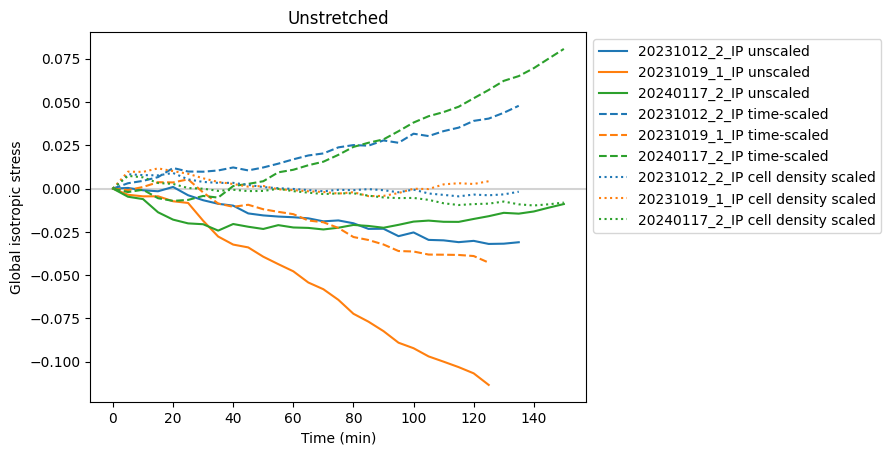

In [199]:
plt.plot(time0, GS0_PA0, label=us_PA_exp[0] + " unscaled", c='tab:blue')
plt.plot(time1, GS1_PA0, label=us_PA_exp[1] + " unscaled",c='tab:orange')
plt.plot(time2, GS2_PA0, label=us_PA_exp[2] + " unscaled",c='tab:green')

plt.plot(time0, GS0_PAs, label=us_PA_exp[0] + " time-scaled", c='tab:blue', linestyle='--')
plt.plot(time1, GS1_PAs, label=us_PA_exp[1] + " time-scaled", c='tab:orange', linestyle='--')
plt.plot(time2, GS2_PAs, label=us_PA_exp[2] + " time-scaled", c='tab:green', linestyle='--')


plt.plot(time0, GS0_PA_cc, label=us_PA_exp[0] + " cell density scaled", c='tab:blue', linestyle=':')
plt.plot(time1, GS1_PA_cc, label=us_PA_exp[1] + " cell density scaled", c='tab:orange', linestyle=':')
plt.plot(time2, GS2_PA_cc, label=us_PA_exp[2] + " cell density scaled", c='tab:green', linestyle=':')

plt.legend(bbox_to_anchor=(1,1), frameon=True)
plt.axhline(0, c='lightgrey', zorder=0)

plt.title("Unstretched")

plt.ylabel("Global isotropic stress")
plt.xlabel("Time (min)")


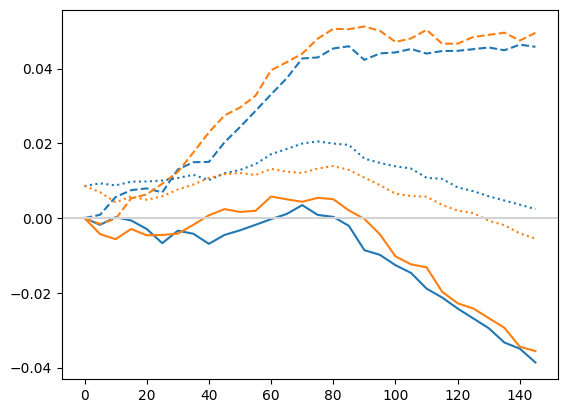

In [80]:
plt.plot(np.unique(cell_data[(cell_data.experiment=='con_20240412_2_IP')].time),[mechanics.GlobalStress(all_pref_areas[all_pref_areas.exp=='con_20240412_2_IP'].pref_area.values, cell_data[(cell_data.experiment=='con_20240412_2_IP')&(cell_data.time==t)].cell_area_microns.values, Gamma,cell_data[(cell_data.experiment=='con_20240412_2_IP')&(cell_data.time==t)].cell_perimeter_microns.values, pref_perimeter) for t in np.unique(cell_data[(cell_data.experiment=='con_20240412_2_IP')].time)])
plt.plot(np.unique(cell_data[(cell_data.experiment=='con_20240503_2_IP')].time),[mechanics.GlobalStress(all_pref_areas[all_pref_areas.exp=='con_20240503_2_IP'].pref_area.values, cell_data[(cell_data.experiment=='con_20240503_2_IP')&(cell_data.time==t)].cell_area_microns.values, Gamma,cell_data[(cell_data.experiment=='con_20240503_2_IP')&(cell_data.time==t)].cell_perimeter_microns.values, pref_perimeter) for t in np.unique(cell_data[(cell_data.experiment=='con_20240503_2_IP')].time)])

plt.plot(np.unique(cell_data[(cell_data.experiment=='con_20240412_2_IP')].time),[mechanics.GlobalStress(all_pref_areas[all_pref_areas.exp=='con_20240412_2_IP'].pref_area.values*(1-area_scaling*(t*60)), cell_data[(cell_data.experiment=='con_20240412_2_IP')&(cell_data.time==t)].cell_area_microns.values, Gamma,cell_data[(cell_data.experiment=='con_20240412_2_IP')&(cell_data.time==t)].cell_perimeter_microns.values, pref_perimeter) for t in np.unique(cell_data[(cell_data.experiment=='con_20240412_2_IP')].time)], linestyle='--', c='tab:blue')
plt.plot(np.unique(cell_data[(cell_data.experiment=='con_20240503_2_IP')].time),[mechanics.GlobalStress(all_pref_areas[all_pref_areas.exp=='con_20240503_2_IP'].pref_area.values*(1-area_scaling*(t*60)), cell_data[(cell_data.experiment=='con_20240503_2_IP')&(cell_data.time==t)].cell_area_microns.values, Gamma,cell_data[(cell_data.experiment=='con_20240503_2_IP')&(cell_data.time==t)].cell_perimeter_microns.values, pref_perimeter) for t in np.unique(cell_data[(cell_data.experiment=='con_20240503_2_IP')].time)], linestyle='--', c='tab:orange')

plt.plot(np.unique(cell_data[(cell_data.experiment=='con_20240412_2_IP')].time),[mechanics.GlobalStress(all_pref_areas[(all_pref_areas.exp=='con_20240412_2_IP')&(all_pref_areas.time==0)].pref_area.values*(slope*exp_data[(exp_data.experiment=='con_20240412_2_IP')].cd_norm+intercept).values[n], cell_data[(cell_data.experiment=='con_20240412_2_IP')&(cell_data.time==np.unique(cell_data[(cell_data.experiment=='con_20240412_2_IP')].time)[n])].cell_area_microns.values, Gamma,cell_data[(cell_data.experiment=='con_20240412_2_IP')&(cell_data.time==np.unique(cell_data[(cell_data.experiment=='con_20240412_2_IP')].time)[n])].cell_perimeter_microns.values, pref_perimeter) for n in range(len(np.unique(cell_data[(cell_data.experiment=='con_20240412_2_IP')].time)))], linestyle=':', color='tab:blue')
plt.plot(np.unique(cell_data[(cell_data.experiment=='con_20240503_2_IP')].time),[mechanics.GlobalStress(all_pref_areas[(all_pref_areas.exp=='con_20240503_2_IP')&(all_pref_areas.time==0)].pref_area.values*(slope*exp_data[(exp_data.experiment=='con_20240503_2_IP')].cd_norm+intercept).values[n], cell_data[(cell_data.experiment=='con_20240503_2_IP')&(cell_data.time==np.unique(cell_data[(cell_data.experiment=='con_20240503_2_IP')].time)[n])].cell_area_microns.values, Gamma,cell_data[(cell_data.experiment=='con_20240503_2_IP')&(cell_data.time==np.unique(cell_data[(cell_data.experiment=='con_20240503_2_IP')].time)[n])].cell_perimeter_microns.values, pref_perimeter) for n in range(len(np.unique(cell_data[(cell_data.experiment=='con_20240503_2_IP')].time)))], linestyle=':', color='tab:orange')


plt.axhline(0, c='lightgrey')

In [258]:
exp_data['tot_area_recip']=1/exp_data.total_area
exp_data['tot_area_norm_recip']=1/exp_data.total_area_norm

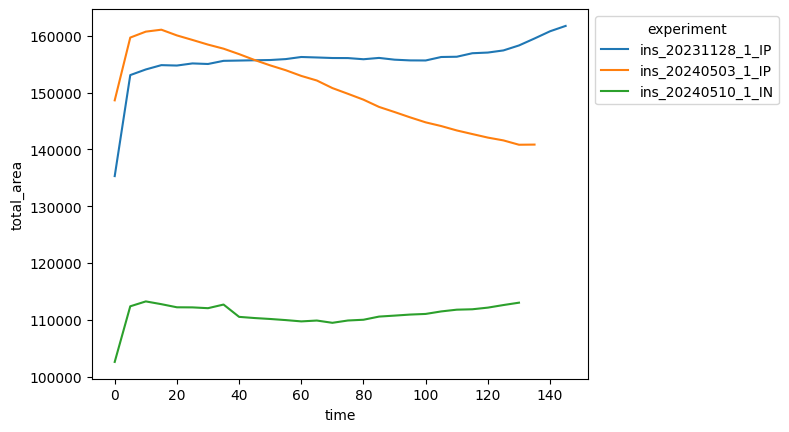

In [255]:
g=sns.lineplot(exp_data[(exp_data.experiment!='ins_20231121_1_IN')&(exp_data.stretch_type=='f')], x='time', y='total_area', hue='experiment')

sns.move_legend(g, "upper left", bbox_to_anchor=(1,1), frameon=True)

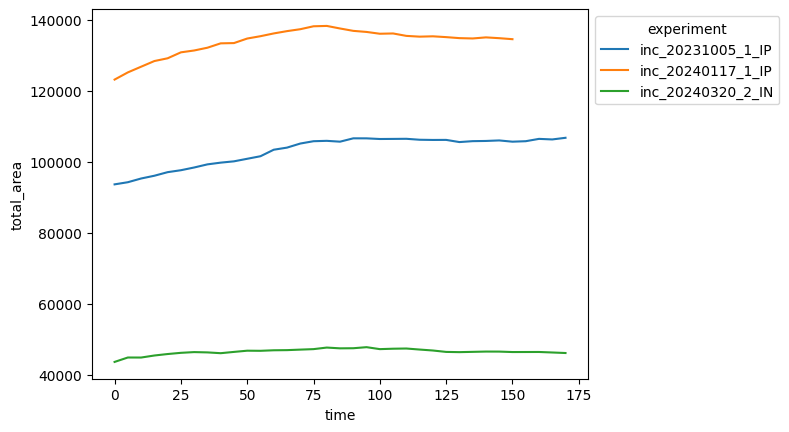

In [256]:
g=sns.lineplot(exp_data[(exp_data.experiment!='ins_20231121_1_IN')&(exp_data.stretch_type=='s')], x='time', y='total_area', hue='experiment')

sns.move_legend(g, "upper left", bbox_to_anchor=(1,1), frameon=True)

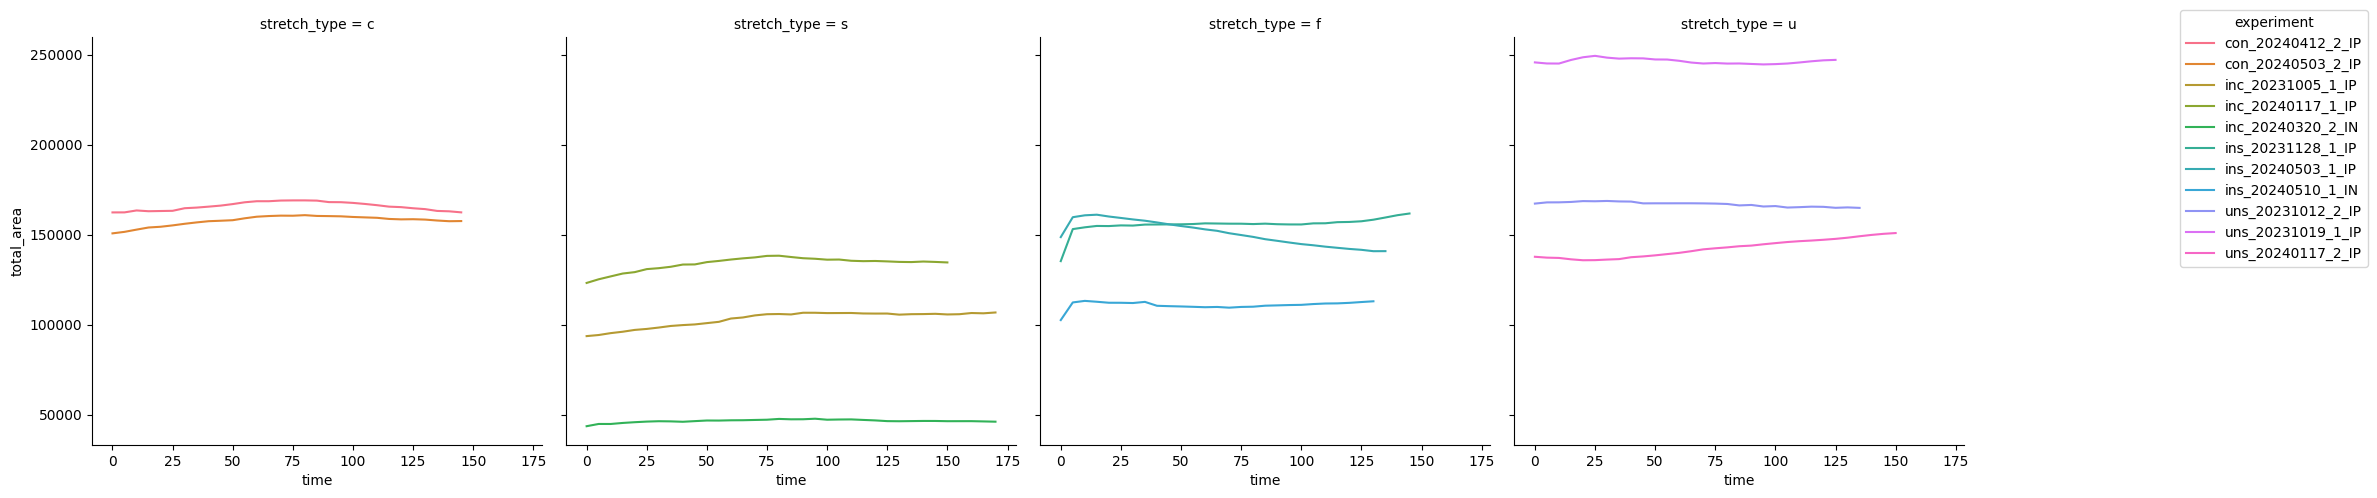

In [259]:
g=sns.relplot(exp_data[exp_data.experiment!='ins_20231121_1_IN'], x='time', y='total_area', hue='experiment', col='stretch_type', kind='line')
sns.move_legend(g, "upper left", bbox_to_anchor=(1,1), frameon=True)


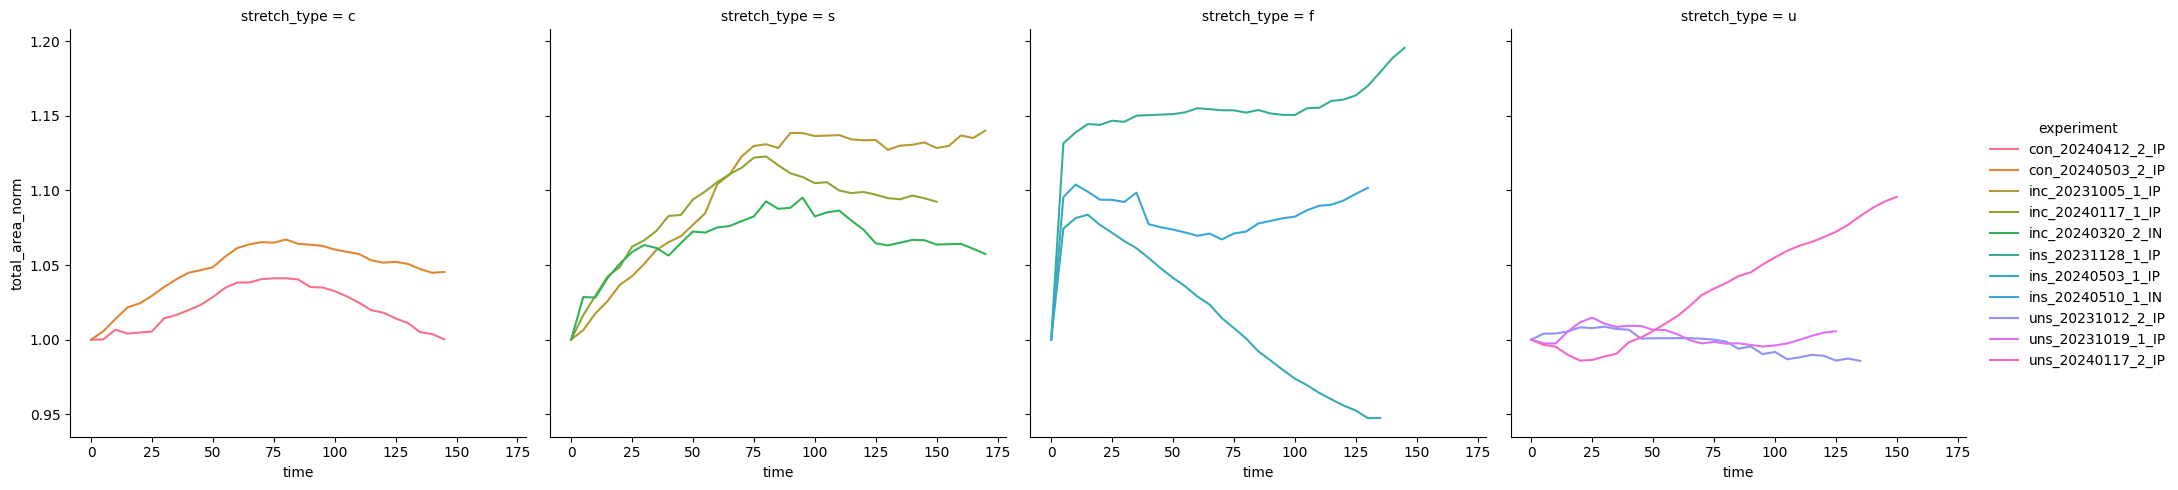

In [262]:
g=sns.relplot(exp_data[exp_data.experiment!='ins_20231121_1_IN'], x='time', y='total_area_norm', hue='experiment', col='stretch_type', kind='line')
#sns.move_legend(g, "upper left", bbox_to_anchor=(1,1), frameon=True)

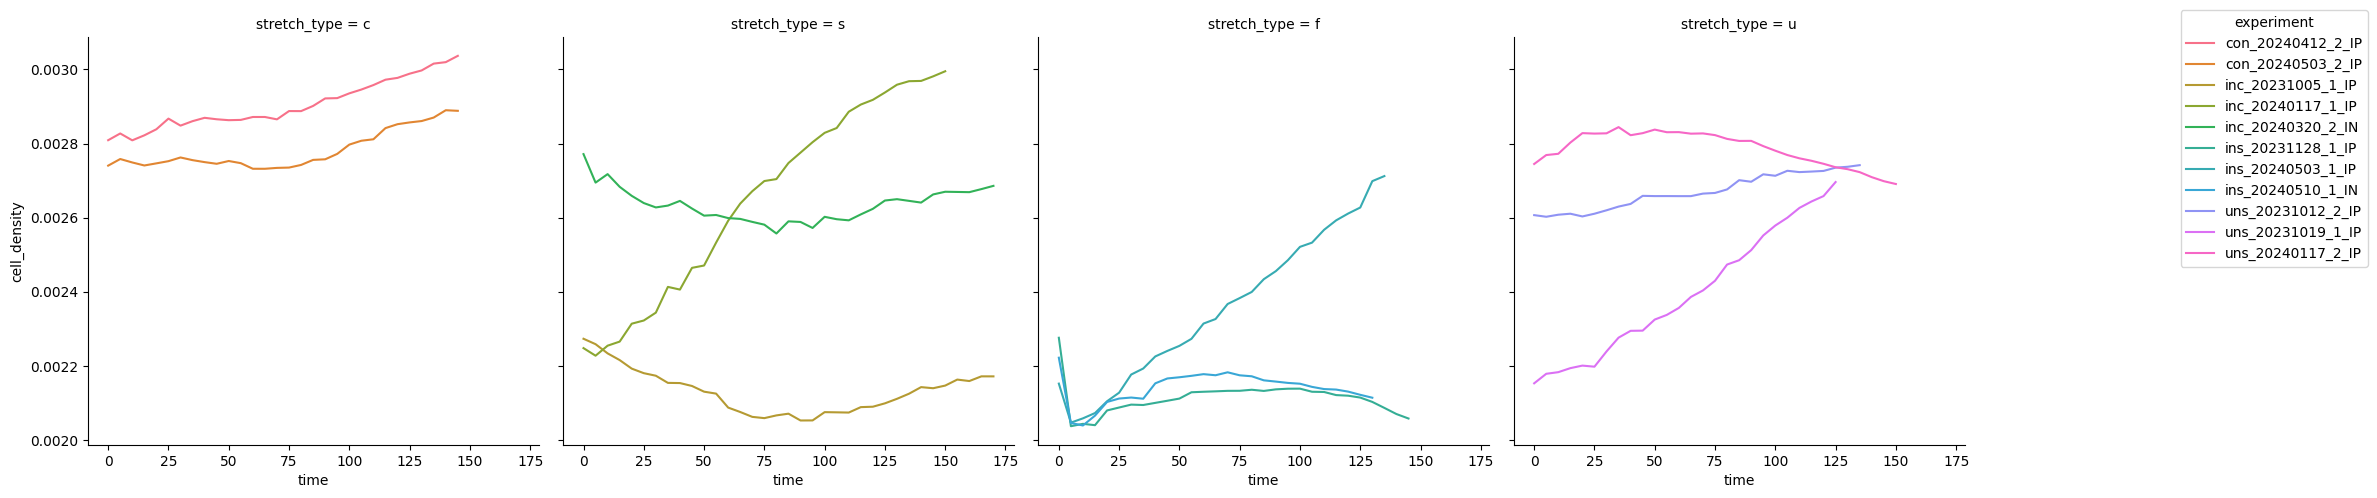

In [96]:
g=sns.relplot(exp_data[exp_data.experiment!='ins_20231121_1_IN'], x='time', y='cell_density', hue='experiment', col='stretch_type', kind='line')
sns.move_legend(g, "upper left", bbox_to_anchor=(1,1), frameon=True)


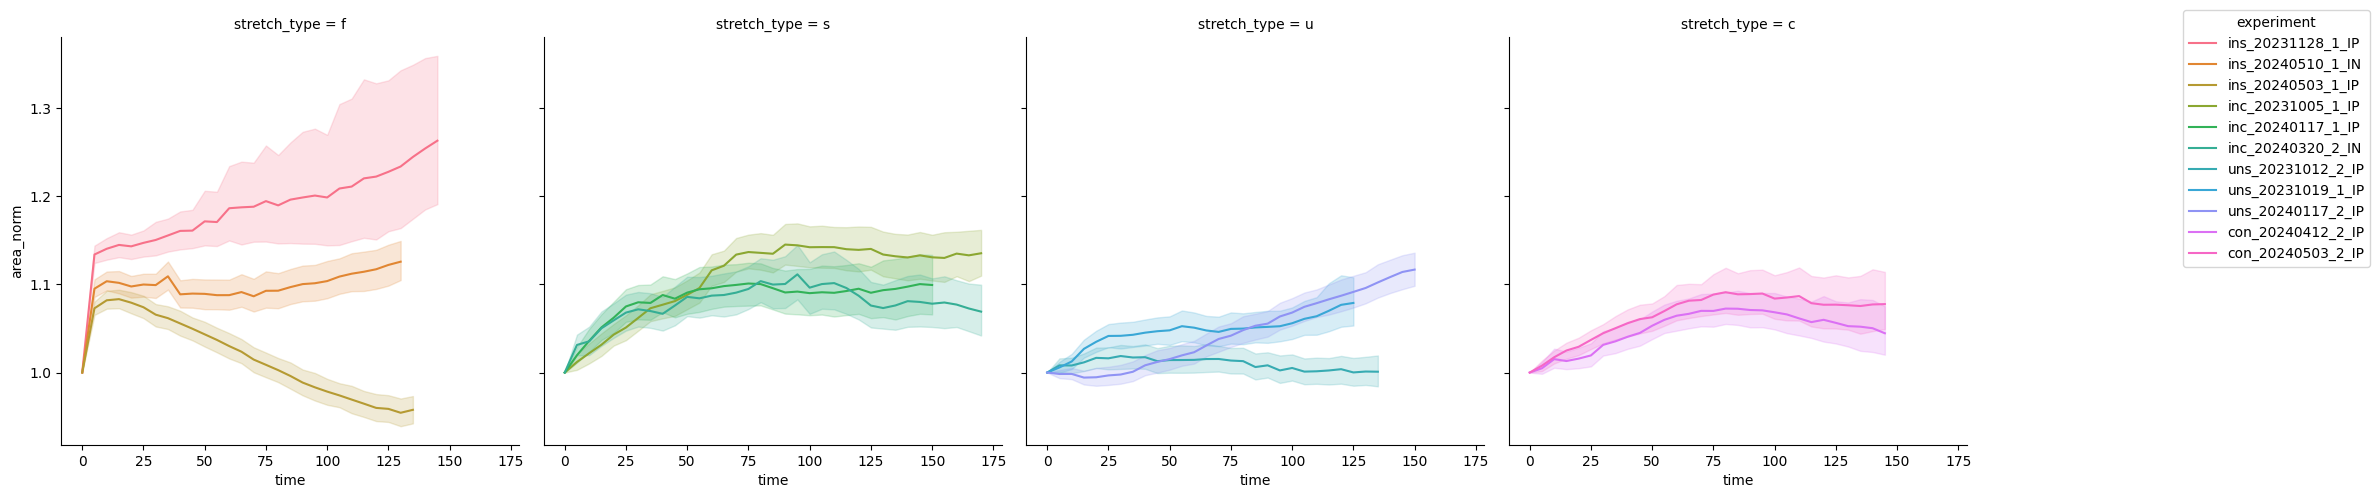

In [264]:
g=sns.relplot(cell_data[cell_data.experiment!='ins_20231121_1_IN'], x='time', y='area_norm', hue='experiment', col='stretch_type', kind='line')
sns.move_legend(g, "upper left", bbox_to_anchor=(1,1), frameon=True)


<AxesSubplot: xlabel='cell_edge_count', ylabel='cell_area_microns'>

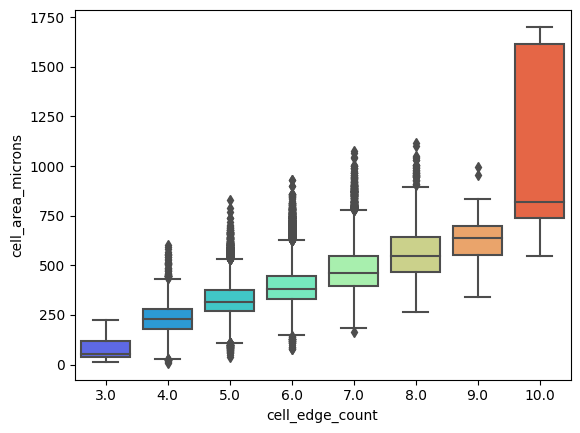

In [189]:
sns.boxplot(cell_data, y='cell_area_microns',x='cell_edge_count', palette='rainbow')

In [155]:
def get_Peff_test(A0, areas, perimeters, Gamma, L0):
    areas_nd=areas/A0
    perimeters_nd=perimeters/np.sqrt(A0)
    pressures=areas_nd-1
    tensions=Gamma*(perimeters_nd-L0)
    Peff_nd=pressures+(perimeters_nd*tensions)/(2*areas_nd)
    
    return Peff_nd

inc_20231005_1_IP


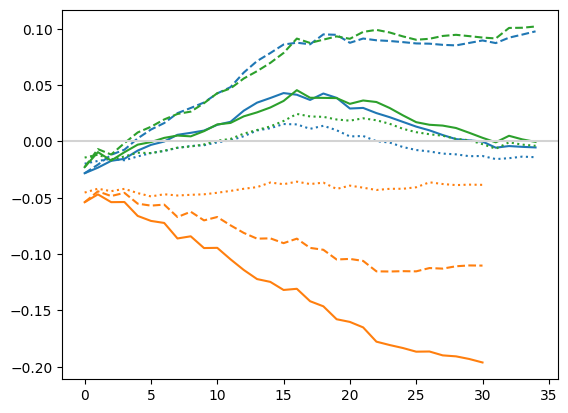

In [192]:
exp_test=np.unique(cell_data.experiment.values)[2]
print(exp_test)
plt.plot([np.mean(get_Peff_test(all_pref_areas[(all_pref_areas.exp==exp_test)&(all_pref_areas.time==0)].pref_area.values, cell_data[(cell_data.experiment==exp_test)&(cell_data.time==t)].cell_area_microns.values, cell_data[(cell_data.experiment==exp_test)&(cell_data.time==t)].cell_perimeter_microns.values, Gamma,pref_perimeter)) for t in np.unique(cell_data[(cell_data.experiment==exp_test)].time)])
plt.plot([np.mean(get_Peff_test(all_pref_areas[(all_pref_areas.exp==exp_test)&(all_pref_areas.time==0)].pref_area.values*(1-area_scaling*(t*60)), cell_data[(cell_data.experiment==exp_test)&(cell_data.time==t)].cell_area_microns.values, cell_data[(cell_data.experiment==exp_test)&(cell_data.time==t)].cell_perimeter_microns.values, Gamma, pref_perimeter)) for t in np.unique(cell_data[(cell_data.experiment==exp_test)].time)], linestyle='--', color='tab:blue')
plt.plot([np.mean(get_Peff_test(all_pref_areas[(all_pref_areas.exp==exp_test)&(all_pref_areas.time==0)].pref_area.values*(slope*exp_data[(exp_data.experiment==exp_test)].cd_norm+intercept).values[n], cell_data[(cell_data.experiment==exp_test)&(cell_data.time==np.unique(cell_data[(cell_data.experiment==exp_test)].time)[n])].cell_area_microns.values, cell_data[(cell_data.experiment==exp_test)&(cell_data.time==np.unique(cell_data[(cell_data.experiment==exp_test)].time)[n])].cell_perimeter_microns.values, Gamma,pref_perimeter)) for n in range(len(np.unique(cell_data[(cell_data.experiment==exp_test)].time)))], linestyle=':', color='tab:blue')

exp_test=np.unique(cell_data.experiment.values)[3]

plt.plot([np.mean(get_Peff_test(all_pref_areas[(all_pref_areas.exp==exp_test)&(all_pref_areas.time==0)].pref_area.values, cell_data[(cell_data.experiment==exp_test)&(cell_data.time==t)].cell_area_microns.values, cell_data[(cell_data.experiment==exp_test)&(cell_data.time==t)].cell_perimeter_microns.values, Gamma,pref_perimeter)) for t in np.unique(cell_data[(cell_data.experiment==exp_test)].time)])
plt.plot([np.mean(get_Peff_test(all_pref_areas[(all_pref_areas.exp==exp_test)&(all_pref_areas.time==0)].pref_area.values*(1-area_scaling*(t*60)), cell_data[(cell_data.experiment==exp_test)&(cell_data.time==t)].cell_area_microns.values, cell_data[(cell_data.experiment==exp_test)&(cell_data.time==t)].cell_perimeter_microns.values, Gamma, pref_perimeter)) for t in np.unique(cell_data[(cell_data.experiment==exp_test)].time)], linestyle='--', color='tab:orange')
plt.plot([np.mean(get_Peff_test(all_pref_areas[(all_pref_areas.exp==exp_test)&(all_pref_areas.time==0)].pref_area.values*(slope*exp_data[(exp_data.experiment==exp_test)].cd_norm+intercept).values[n], cell_data[(cell_data.experiment==exp_test)&(cell_data.time==np.unique(cell_data[(cell_data.experiment==exp_test)].time)[n])].cell_area_microns.values, cell_data[(cell_data.experiment==exp_test)&(cell_data.time==np.unique(cell_data[(cell_data.experiment==exp_test)].time)[n])].cell_perimeter_microns.values, Gamma,pref_perimeter)) for n in range(len(np.unique(cell_data[(cell_data.experiment==exp_test)].time)))], linestyle=':', color='tab:orange')
exp_test=np.unique(cell_data.experiment.values)[4]

plt.plot([np.mean(get_Peff_test(all_pref_areas[(all_pref_areas.exp==exp_test)&(all_pref_areas.time==0)].pref_area.values, cell_data[(cell_data.experiment==exp_test)&(cell_data.time==t)].cell_area_microns.values, cell_data[(cell_data.experiment==exp_test)&(cell_data.time==t)].cell_perimeter_microns.values, Gamma,pref_perimeter)) for t in np.unique(cell_data[(cell_data.experiment==exp_test)].time)])
plt.plot([np.mean(get_Peff_test(all_pref_areas[(all_pref_areas.exp==exp_test)&(all_pref_areas.time==0)].pref_area.values*(1-area_scaling*(t*60)), cell_data[(cell_data.experiment==exp_test)&(cell_data.time==t)].cell_area_microns.values, cell_data[(cell_data.experiment==exp_test)&(cell_data.time==t)].cell_perimeter_microns.values, Gamma, pref_perimeter)) for t in np.unique(cell_data[(cell_data.experiment==exp_test)].time)], linestyle='--', color='tab:green')
plt.plot([np.mean(get_Peff_test(all_pref_areas[(all_pref_areas.exp==exp_test)&(all_pref_areas.time==0)].pref_area.values*(slope*exp_data[(exp_data.experiment==exp_test)].cd_norm+intercept).values[n], cell_data[(cell_data.experiment==exp_test)&(cell_data.time==np.unique(cell_data[(cell_data.experiment==exp_test)].time)[n])].cell_area_microns.values, cell_data[(cell_data.experiment==exp_test)&(cell_data.time==np.unique(cell_data[(cell_data.experiment==exp_test)].time)[n])].cell_perimeter_microns.values, Gamma,pref_perimeter)) for n in range(len(np.unique(cell_data[(cell_data.experiment==exp_test)].time)))], linestyle=':', color='tab:green')
plt.axhline(0, color='lightgrey')

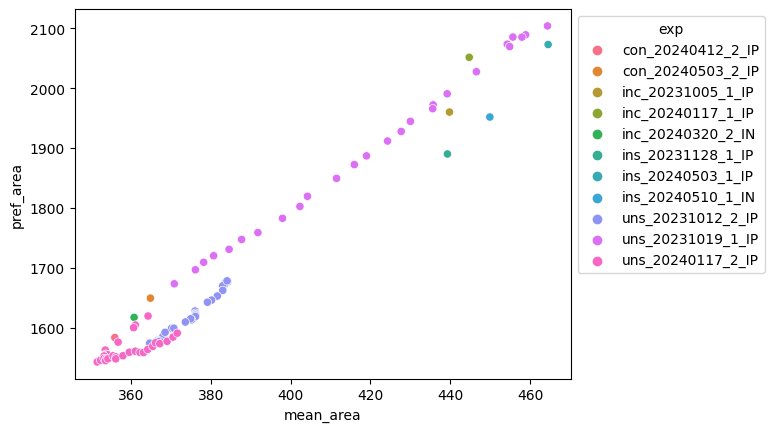

In [19]:
g=sns.scatterplot(all_pref_areas, x='mean_area', y='pref_area', hue='exp')
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))




In [226]:
stats.linregress(all_pref_areas.mean_area,all_pref_areas.pref_area)

LinregressResult(slope=5.164106486709225, intercept=-292.9066683389008, rvalue=0.9866608968714908, pvalue=1.5304647809484908e-73, stderr=0.08931651376860593, intercept_stderr=34.55188523096225)

In [240]:
np.mean(all_pref_areas.pref_area/all_pref_areas.mean_area)

4.399108668565515

In [18]:
all_pref_areas['mean_area_norm']=all_pref_areas.mean_area/all_pref_areas.groupby(["exp"]).mean_area.transform("first")

Text(0, 0.5, 'Normalised preferred area')

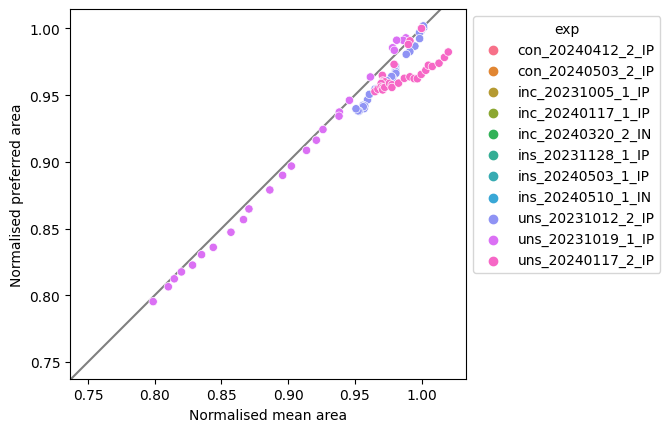

In [247]:
g=sns.scatterplot(all_pref_areas, x='mean_area_norm', y='pa_norm', hue='exp')
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
plt.axline(xy1=(0.75,0.75), slope=1, c='grey', zorder=0)
plt.gca().set_aspect('equal')
plt.xlabel("Normalised mean area")
plt.ylabel("Normalised preferred area")


In [11]:
cell_data.groupby(["experiment", "time", "cell_edge_count"]).mean().cell_area_nd

C:\Users\v35431nc\AppData\Local\Temp\ipykernel_15704\647954478.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cell_data.groupby(["experiment", "time", "cell_edge_count"]).mean().cell_area_nd


experiment         time  cell_edge_count
con_20240412_2_IP  0     4.0                0.148959
                         5.0                0.188408
                         6.0                0.222362
                         7.0                0.269035
                         8.0                0.311132
                                              ...   
uns_20240117_2_IP  150   4.0                0.131594
                         5.0                0.195684
                         6.0                0.227330
                         7.0                0.285712
                         8.0                0.320902
Name: cell_area_nd, Length: 1909, dtype: float64

<AxesSubplot: xlabel='cell_area_nd', ylabel='Count'>

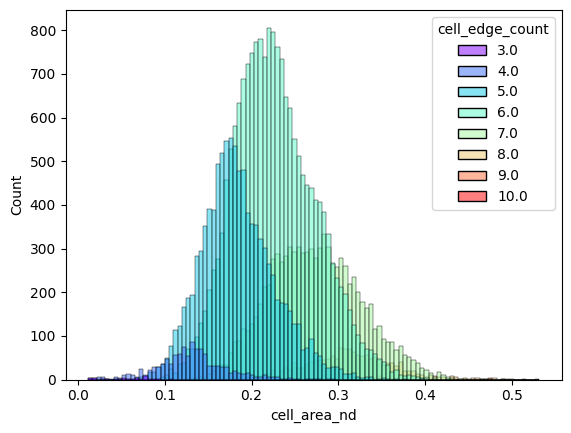

In [27]:
sns.histplot(cell_data[cell_data.stretch_type=='u'], x='cell_area_nd', hue='cell_edge_count', palette='rainbow')

In [31]:
cell_data[cell_data.stretch_type=='u'].groupby('cell_edge_count').cell_area_nd.describe()

,count,mean,std,min,25%,50%,75%,max
cell_edge_count,,,,,,,,
3.0,35.0,0.061293,0.026380,0.011790,0.046647,0.067985,0.079730,0.109618
4.0,1122.0,0.131068,0.041261,0.013056,0.107018,0.130847,0.151338,0.293721
5.0,10070.0,0.184217,0.042432,0.021446,0.156145,0.180039,0.209495,0.396500
6.0,18479.0,0.226786,0.047276,0.077187,0.193219,0.222936,0.257526,0.426545
7.0,8770.0,0.273585,0.052419,0.125450,0.235293,0.271621,0.309171,0.439447
8.0,1539.0,0.311999,0.053146,0.155209,0.277361,0.311652,0.345000,0.531411
9.0,87.0,0.350281,0.066059,0.224491,0.313219,0.340374,0.388469,0.512875
10.0,2.0,0.321380,0.004450,0.318233,0.319807,0.321380,0.322953,0.324527


(array([1.2500e+02, 2.6040e+03, 1.3718e+04, 1.4026e+04, 7.0270e+03,
        2.2330e+03, 3.3200e+02, 3.8000e+01, 0.0000e+00, 1.0000e+00]),
 array([0.0114771 , 0.07538328, 0.13928946, 0.20319564, 0.26710182,
        0.33100801, 0.39491419, 0.45882037, 0.52272655, 0.58663273,
        0.65053891]),
 <BarContainer object of 10 artists>)

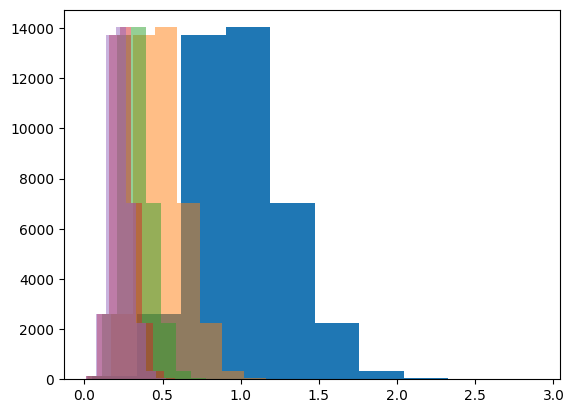

In [23]:
plt.hist(cell_data[cell_data.stretch_type=='u'].cell_area_microns/cell_data[cell_data.stretch_type=='u'].cell_area_microns.mean())
plt.hist(cell_data[cell_data.stretch_type=='u'].cell_area_microns/(2*cell_data[cell_data.stretch_type=='u'].cell_area_microns.mean()), alpha=0.5)
plt.hist(cell_data[cell_data.stretch_type=='u'].cell_area_microns/(3*cell_data[cell_data.stretch_type=='u'].cell_area_microns.mean()),alpha=0.5)
plt.hist(cell_data[cell_data.stretch_type=='u'].cell_area_microns/(4*cell_data[cell_data.stretch_type=='u'].cell_area_microns.mean()),alpha=0.5)
plt.hist(cell_data[cell_data.stretch_type=='u'].cell_area_microns/(4.45*cell_data[cell_data.stretch_type=='u'].cell_area_microns.mean()),alpha=0.5)